# MAS 651 Mid-Term Project: Predicting HDL Cholesterol
## 2026 ASA South Florida Student Data Challenge — Graduate Prediction Track

**Team Members:** Daniel Regalado & Miguel Rocha

**Date:** February 2026

**Objective:** Predict Direct HDL-Cholesterol (`LBDHDD_outcome`) from NHANES demographic, dietary, behavioral, and body-measure variables with minimum RMSE.

**Data Source:** [ASA South Florida Student Data Challenge](https://luminwin.github.io/ASASF/)

---

## 0. Environment Setup

In [1]:
import subprocess, sys

packages = [
    "pandas", "numpy", "scikit-learn", "matplotlib", "seaborn",
    "xgboost", "lightgbm", "catboost", "shap", "lime",
    "tensorflow", "optuna", "jupyter", "ipykernel"
]
for pkg in packages:
    subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", pkg])

print("All packages installed successfully!")


[notice] A new release of pip is available: 25.3 -> 26.0.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 25.3 -> 26.0.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 25.3 -> 26.0.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 25.3 -> 26.0.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 25.3 -> 26.0.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 25.3 -> 26.0.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 25.3 -> 26.0.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 25.3 -> 26.0.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 25.3 -> 26.0.1
[notice] To update, run: pip install --upgrade pip



All packages installed successfully!



[notice] A new release of pip is available: 25.3 -> 26.0.1
[notice] To update, run: pip install --upgrade pip


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from scipy import stats
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.model_selection import (
    GridSearchCV, KFold, train_test_split, cross_val_score
)
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import ElasticNet
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 11
sns.set_style('whitegrid')

SEED = 42
np.random.seed(SEED)

---
## 1. Data Loading

Load training data (1,000 rows), test data (200 rows), and human-readable variable labels from the competition GitHub repository.

In [3]:
!pip -q install pyreadr
# Load datasets
import requests, tempfile, pyreadr

def read_rds_from_url(url):
    r = requests.get(url)
    r.raise_for_status()
    with tempfile.NamedTemporaryFile(suffix=".rds") as f:
        f.write(r.content)
        f.flush()
        obj = pyreadr.read_r(f.name)
    return list(obj.values())[0]

train = read_rds_from_url("https://luminwin.github.io/ASASF/train.rds")
test  = read_rds_from_url("https://luminwin.github.io/ASASF/test.rds")
# Load variable labels for interpretability
labels_url = "https://raw.githubusercontent.com/luminwin/ASASF/main/variable_labels.csv"
try:
    labels_df = pd.read_csv(labels_url)
    label_map = dict(zip(labels_df.iloc[:, 0], labels_df.iloc[:, 1]))
    print(f"Loaded {len(label_map)} variable labels from GitHub")
except:
    label_map = {}
    print("Could not load labels, using column names as-is")

def get_label(col):
    """Get human-readable label for a column."""
    if col in label_map:
        return f"{col} ({label_map[col]})"
    return col

# Basic info
TARGET = 'LBDHDD_outcome'
X_full = train.drop(columns=[TARGET])
y_full = train[TARGET]
X_test = test.copy()

print(f"\nTraining set: {train.shape[0]} rows x {train.shape[1]} columns")
print(f"Test set: {test.shape[0]} rows x {test.shape[1]} columns")
print(f"Target: {TARGET} (Direct HDL-Cholesterol in mg/dL)")
print(f"Target range: [{y_full.min():.1f}, {y_full.max():.1f}] mg/dL")
print(f"Target mean: {y_full.mean():.2f}, median: {y_full.median():.2f}")


[notice] A new release of pip is available: 25.3 -> 26.0.1
[notice] To update, run: pip install --upgrade pip
Loaded 96 variable labels from GitHub

Training set: 1000 rows x 96 columns
Test set: 200 rows x 95 columns
Target: LBDHDD_outcome (Direct HDL-Cholesterol in mg/dL)
Target range: [30.0, 86.7] mg/dL
Target mean: 54.73, median: 54.16


**Analysis — Data Loading**

## Data Loading and Initial Inspection

The dataset was successfully loaded and verified prior to analysis. The training dataset contains **1,000 observations and 96 variables**, while the test dataset contains **200 observations and 95 variables**, excluding the target variable.

The prediction target is **LBDHDD_outcome**, representing direct HDL cholesterol levels measured in **mg/dL**.

### Dataset Summary

- Training set: 1,000 rows × 96 columns  
- Test set: 200 rows × 95 columns  
- Target variable: *LBDHDD_outcome* (HDL Cholesterol)  
- Target range: 30.0 – 86.7 mg/dL  
- Target mean: 54.73 mg/dL  
- Target median: 54.16 mg/dL  

The similarity between the mean and median suggests that the target distribution is approximately symmetric, with no immediate indication of strong skewness. This supports the use of standard regression models without requiring transformation of the target variable at this stage.

The dataset includes demographic, dietary, behavioral, and body-measure variables derived from the NHANES program, providing a heterogeneous set of predictors suitable for both linear and non-linear modeling approaches.

In the following section, exploratory data analysis (EDA) is conducted to assess missingness patterns, feature distributions, and relationships with the target variable before feature engineering and model development.

---
## Task A — Data Quality and Structure (Visualization)

### A.1 Missingness by Feature

In [4]:
# Missingness analysis
total_missing = X_full.isnull().sum().sum()
print(f"Total missing values: {total_missing}")

if total_missing > 0:
    missing_pct = (X_full.isnull().sum() / len(X_full) * 100).sort_values(ascending=False)
    missing_pct = missing_pct[missing_pct > 0]

    fig, ax = plt.subplots(figsize=(14, max(4, len(missing_pct) * 0.3)))
    missing_pct.plot(kind='barh', color='coral', ax=ax)
    ax.set_xlabel('Missing (%)')
    ax.set_title('Missingness by Feature (% Missing)')
    plt.tight_layout()
    plt.show()

    print(f"\nFeatures with missing values: {len(missing_pct)}")
    for col, pct in missing_pct.head(20).items():
        print(f"  {get_label(col)}: {pct:.1f}%")
else:
    print("No missing values in training data!")
    print("\nTest set missing values:", X_test.isnull().sum().sum())

Total missing values: 0
No missing values in training data!

Test set missing values: 0


**Analysis — Missingness**

No missing values were detected in either the training or test datasets. This indicates that no imputation procedures are required during preprocessing, simplifying the modeling pipeline and reducing potential sources of bias introduced by imputation methods.

The absence of missing data allows all available observations to be used during model training and cross-validation, which is particularly beneficial given the relatively small sample size of the dataset.

Although no missingness handling is necessary, preprocessing steps will still ensure consistent feature scaling and encoding across training and test sets.

### A.2 Target Distribution (Histogram + Density)

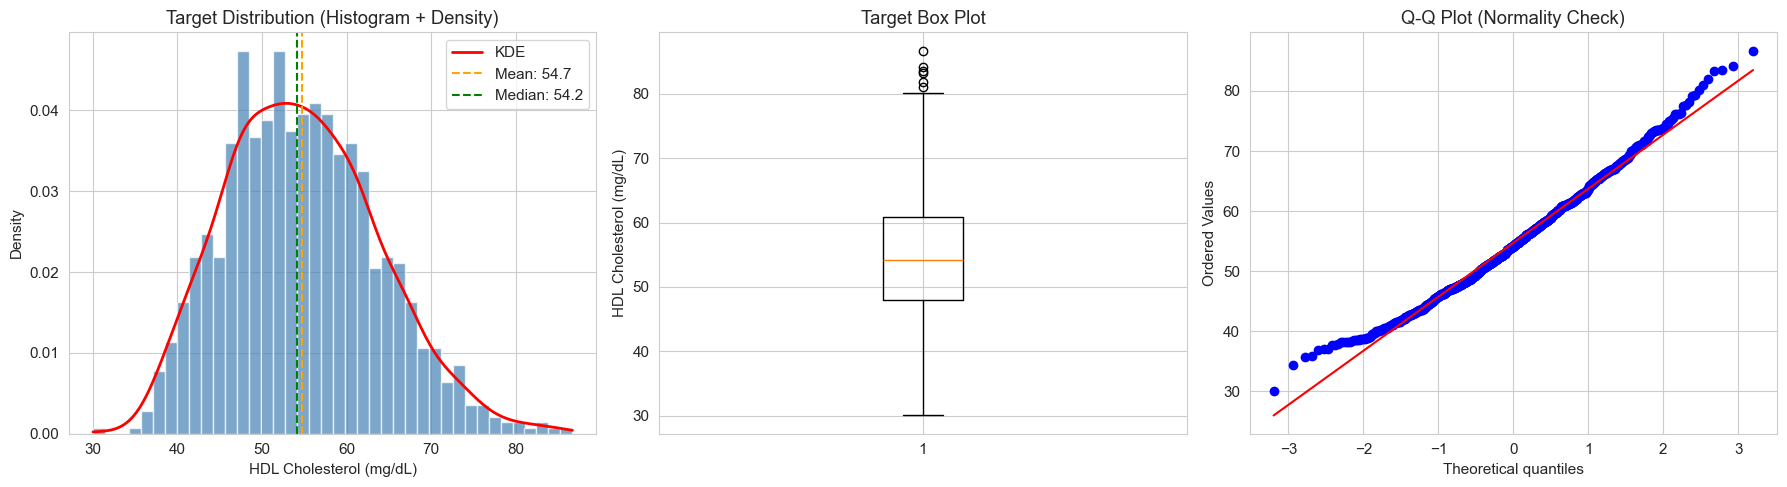

Target Statistics:
  Mean:     54.73 mg/dL
  Median:   54.16 mg/dL
  Std Dev:  9.01
  Skewness: 0.376
  Kurtosis: -0.040
  Range:    [30, 87]


In [5]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Histogram + density
axes[0].hist(y_full, bins=40, density=True, color='steelblue', edgecolor='white', alpha=0.7)
x_kde = np.linspace(y_full.min(), y_full.max(), 200)
kde = stats.gaussian_kde(y_full)
axes[0].plot(x_kde, kde(x_kde), 'r-', linewidth=2, label='KDE')
axes[0].axvline(y_full.mean(), color='orange', linestyle='--', linewidth=1.5, label=f'Mean: {y_full.mean():.1f}')
axes[0].axvline(y_full.median(), color='green', linestyle='--', linewidth=1.5, label=f'Median: {y_full.median():.1f}')
axes[0].set_xlabel('HDL Cholesterol (mg/dL)')
axes[0].set_ylabel('Density')
axes[0].set_title('Target Distribution (Histogram + Density)')
axes[0].legend()

# Box plot
axes[1].boxplot(y_full, vert=True)
axes[1].set_ylabel('HDL Cholesterol (mg/dL)')
axes[1].set_title('Target Box Plot')

# QQ plot
stats.probplot(y_full, dist="norm", plot=axes[2])
axes[2].set_title('Q-Q Plot (Normality Check)')

plt.tight_layout()
plt.show()

print(f"Target Statistics:")
print(f"  Mean:     {y_full.mean():.2f} mg/dL")
print(f"  Median:   {y_full.median():.2f} mg/dL")
print(f"  Std Dev:  {y_full.std():.2f}")
print(f"  Skewness: {y_full.skew():.3f}")
print(f"  Kurtosis: {y_full.kurtosis():.3f}")
print(f"  Range:    [{y_full.min():.0f}, {y_full.max():.0f}]")

**Analysis — Target Distribution**

The target variable (HDL cholesterol) exhibits an approximately symmetric and unimodal distribution centered around 54 mg/dL. The mean (54.73) and median (54.16) are very close, indicating limited skewness and suggesting that extreme asymmetry is not present in the data.

The histogram and kernel density estimate show a near-normal shape, which is further supported by the Q-Q plot where most observations lie close to the theoretical normal line. Minor deviations are observed in the upper tail, indicating the presence of a small number of higher HDL values, as also reflected in the box plot outliers.

The calculated skewness (0.376) confirms a slight right skew, but not at a level that would justify transforming the target variable (e.g., log transformation). Kurtosis close to zero (-0.040) suggests tail behavior similar to a normal distribution.

Overall, the target distribution is well-suited for standard regression approaches, and no transformation of the response variable is required at this stage. Model performance will therefore be evaluated directly in the original units (mg/dL), improving interpretability of prediction errors.

### A.3 Correlation Heatmap for Top Correlated Features

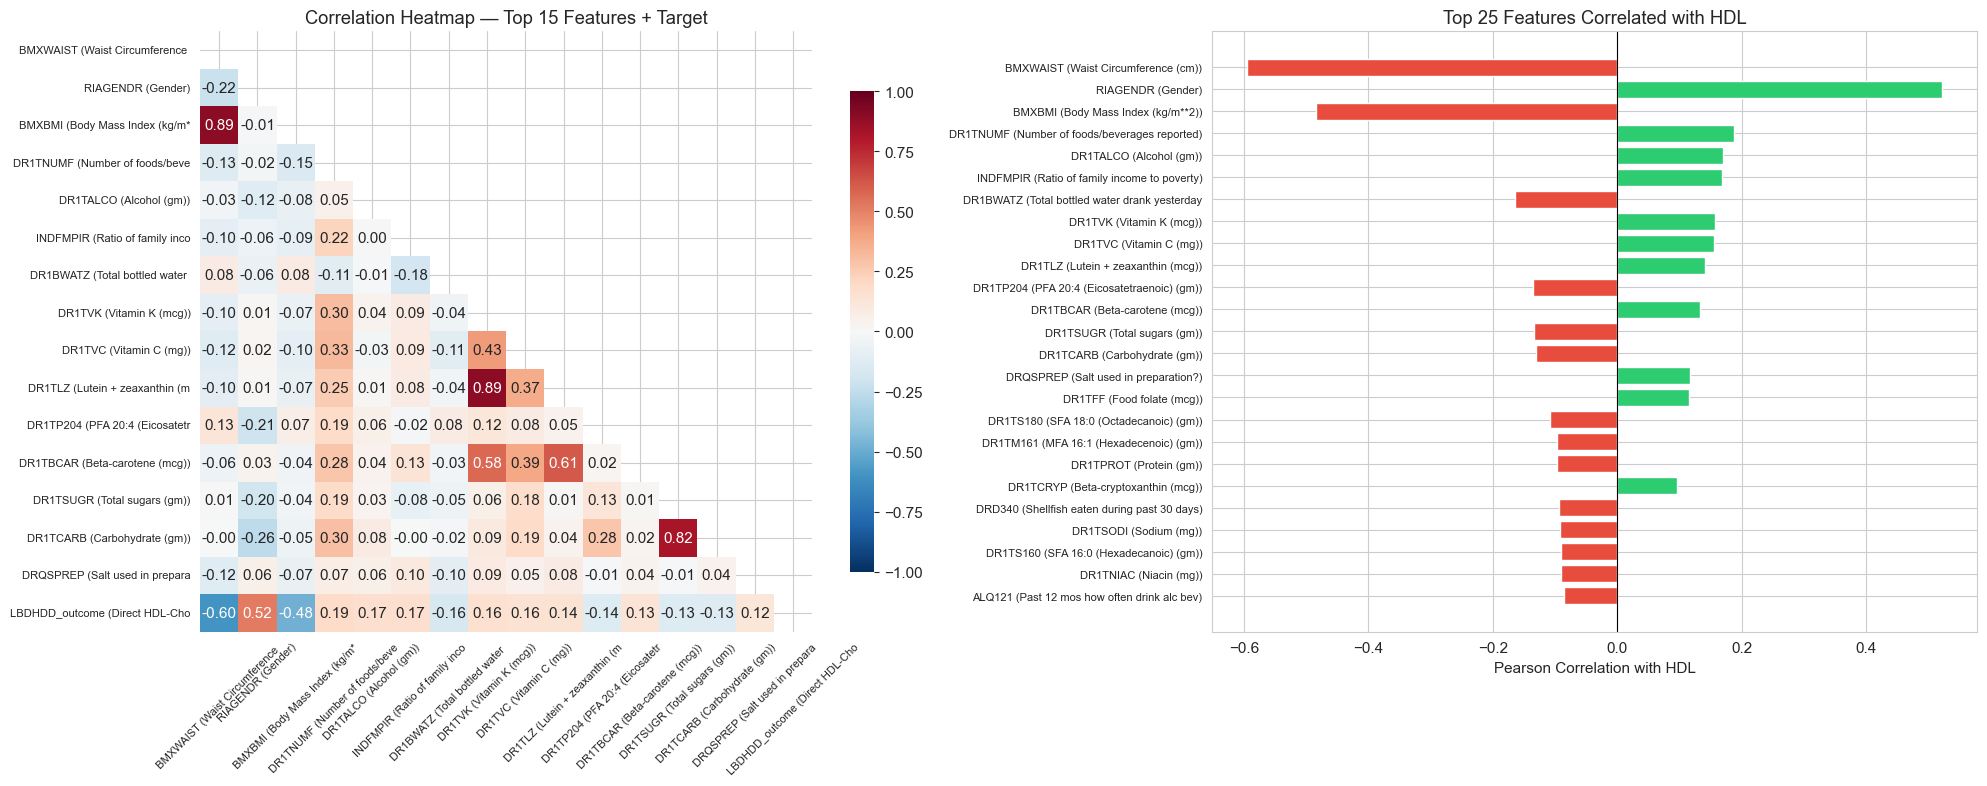


Top 10 Feature Correlations with HDL:
----------------------------------------------------------------------
   1. BMXWAIST (Waist Circumference (cm))                     r = -0.5958
   2. RIAGENDR (Gender)                                       r = +0.5227
   3. BMXBMI (Body Mass Index (kg/m**2))                      r = -0.4840
   4. DR1TNUMF (Number of foods/beverages reported)           r = +0.1882
   5. DR1TALCO (Alcohol (gm))                                 r = +0.1706
   6. INDFMPIR (Ratio of family income to poverty)            r = +0.1692
   7. DR1BWATZ (Total bottled water drank yesterday (gm))     r = -0.1644
   8. DR1TVK (Vitamin K (mcg))                                r = +0.1568
   9. DR1TVC (Vitamin C (mg))                                 r = +0.1561
  10. DR1TLZ (Lutein + zeaxanthin (mcg))                      r = +0.1412


In [6]:
# Compute correlations with target
train_numeric = train.select_dtypes(include=[np.number])
corr_target = train_numeric.corr()[TARGET].drop(TARGET).sort_values(key=abs, ascending=False)

# Top 15 features correlation heatmap
top_feats = corr_target.head(15).index.tolist() + [TARGET]
corr_matrix = train[top_feats].corr()

fig, axes = plt.subplots(1, 2, figsize=(20, 8))

# Heatmap
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
labels_for_heatmap = [get_label(c)[:30] for c in corr_matrix.columns]
sns.heatmap(corr_matrix, mask=mask, annot=True, fmt='.2f', cmap='RdBu_r',
            center=0, vmin=-1, vmax=1, ax=axes[0], cbar_kws={'shrink': 0.8},
            xticklabels=labels_for_heatmap, yticklabels=labels_for_heatmap)
axes[0].set_title('Correlation Heatmap — Top 15 Features + Target')
axes[0].tick_params(axis='x', rotation=45, labelsize=8)
axes[0].tick_params(axis='y', labelsize=8)

# Bar chart of correlations with target
top_25 = corr_target.head(25)
colors = ['#e74c3c' if v < 0 else '#2ecc71' for v in top_25.values]
labels_for_bar = [get_label(c)[:45] for c in top_25.index]
axes[1].barh(range(25), top_25.values, color=colors)
axes[1].set_yticks(range(25))
axes[1].set_yticklabels(labels_for_bar, fontsize=8)
axes[1].set_xlabel('Pearson Correlation with HDL')
axes[1].set_title('Top 25 Features Correlated with HDL')
axes[1].axvline(0, color='black', linewidth=0.8)
axes[1].invert_yaxis()

plt.tight_layout()
plt.show()

# Print top 10
print("\nTop 10 Feature Correlations with HDL:")
print("-" * 70)
for i, (col, r) in enumerate(corr_target.head(10).items(), 1):
    print(f"  {i:2d}. {get_label(col)[:55]:55s} r = {r:+.4f}")

**Analysis — Correlation Analysis**

The correlation analysis reveals several meaningful relationships between predictor variables and HDL cholesterol levels. The strongest negative correlations are observed for **waist circumference (r = -0.596)** and **body mass index (r = -0.484)**, indicating that higher measures of adiposity are associated with lower HDL levels. This is consistent with established clinical findings linking central obesity and reduced HDL cholesterol.

Gender shows a relatively strong positive correlation with HDL (r = +0.523), suggesting systematic differences in HDL levels across groups, making it an important predictor for modeling purposes.

Dietary and behavioral variables such as alcohol intake, number of foods reported, and selected micronutrients (Vitamin K, Vitamin C, lutein + zeaxanthin) exhibit weaker but positive correlations. These variables may contribute incremental predictive value when combined with other features, even if their individual linear relationships are moderate.

Overall, most correlations fall within a low-to-moderate range, indicating that HDL levels are likely influenced by multiple interacting factors rather than a single dominant predictor. This supports the use of non-linear models such as tree-based ensembles and neural networks, which can capture interaction effects beyond simple linear relationships.

It is important to note that correlation does not imply causation; therefore, these observations are used to guide feature engineering and model development rather than to infer causal relationships.

---
## Task B — Relationships (Visualization)

### B.1 HDL vs BMI (Scatter + Trend Line)

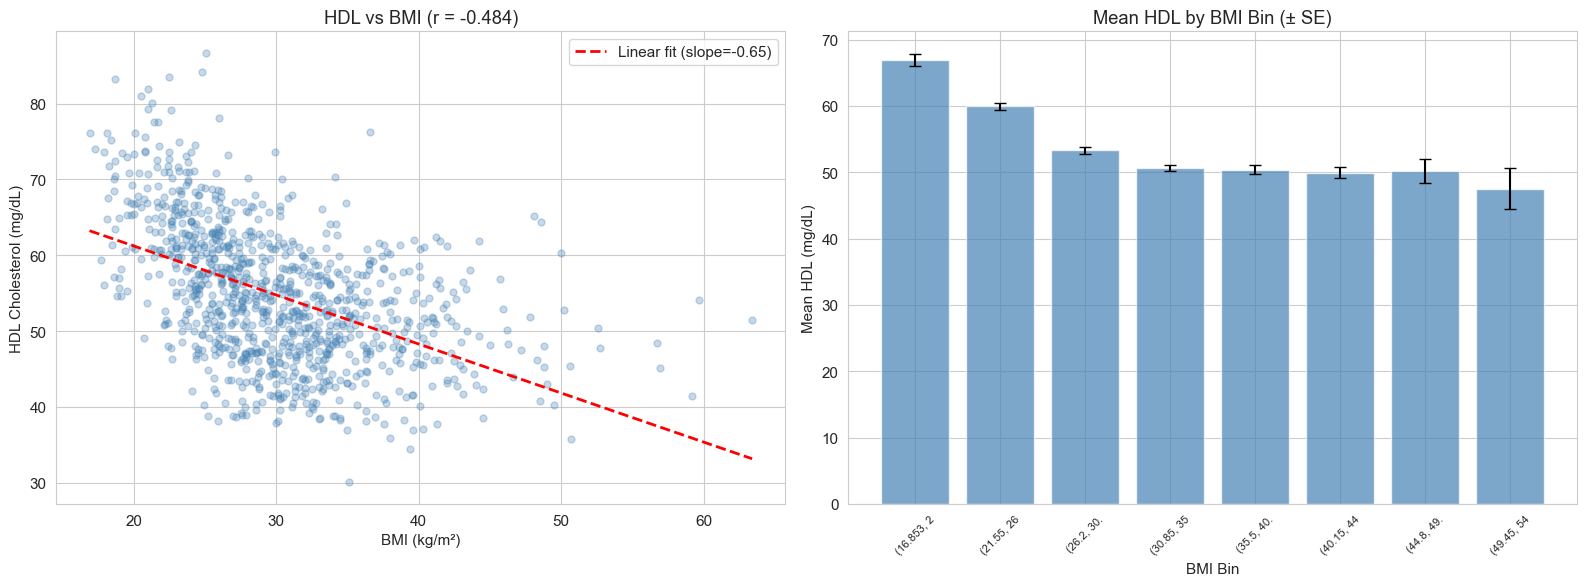

In [7]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Scatter + trend line
ax = axes[0]
ax.scatter(train['BMXBMI'], train[TARGET], alpha=0.3, s=25, c='steelblue')
z = np.polyfit(train['BMXBMI'].dropna(), train[TARGET][train['BMXBMI'].notna()], 1)
p = np.poly1d(z)
x_line = np.linspace(train['BMXBMI'].min(), train['BMXBMI'].max(), 100)
ax.plot(x_line, p(x_line), 'r--', linewidth=2, label=f'Linear fit (slope={z[0]:.2f})')
ax.set_xlabel('BMI (kg/m²)')
ax.set_ylabel('HDL Cholesterol (mg/dL)')
ax.set_title(f'HDL vs BMI (r = {corr_target.get("BMXBMI", 0):.3f})')
ax.legend()

# Binned means
ax = axes[1]
train['BMI_bin'] = pd.cut(train['BMXBMI'], bins=10)
bmi_means = train.groupby('BMI_bin', observed=True)[TARGET].agg(['mean', 'std', 'count'])
bmi_means = bmi_means[bmi_means['count'] >= 5]
x_pos = range(len(bmi_means))
ax.bar(x_pos, bmi_means['mean'], yerr=bmi_means['std']/np.sqrt(bmi_means['count']),
       color='steelblue', alpha=0.7, capsize=4)
ax.set_xticks(x_pos)
ax.set_xticklabels([str(b)[:10] for b in bmi_means.index], rotation=45, fontsize=8)
ax.set_ylabel('Mean HDL (mg/dL)')
ax.set_xlabel('BMI Bin')
ax.set_title('Mean HDL by BMI Bin (± SE)')
train.drop(columns=['BMI_bin'], inplace=True)

plt.tight_layout()
plt.show()

**Analysis — HDL vs BMI**

The relationship between HDL cholesterol and Body Mass Index (BMI) shows a clear negative association, with higher BMI values generally corresponding to lower HDL levels (r = -0.484). The scatter plot indicates a consistent downward trend, confirmed by the negative slope of the fitted linear regression line.

While the overall relationship appears approximately linear, the binned analysis suggests that the decline in HDL is not perfectly uniform across BMI ranges. HDL levels decrease more sharply between lower and moderate BMI ranges, while changes become less pronounced at higher BMI levels. This pattern suggests the presence of mild non-linearity and potential threshold effects.

The dispersion of points around the trend line indicates that BMI alone does not fully explain HDL variability, reinforcing the idea that HDL levels are influenced by multiple physiological and behavioral factors.

From a modeling perspective, BMI is expected to be an important predictive feature. However, the observed variability supports the use of models capable of capturing non-linear relationships and interactions (e.g., tree-based ensemble methods or neural networks). Additionally, this relationship motivates potential feature engineering approaches such as BMI categorization or interaction terms with demographic or lifestyle variables.

### B.2 HDL by Subgroup (Box/Violin Plots)

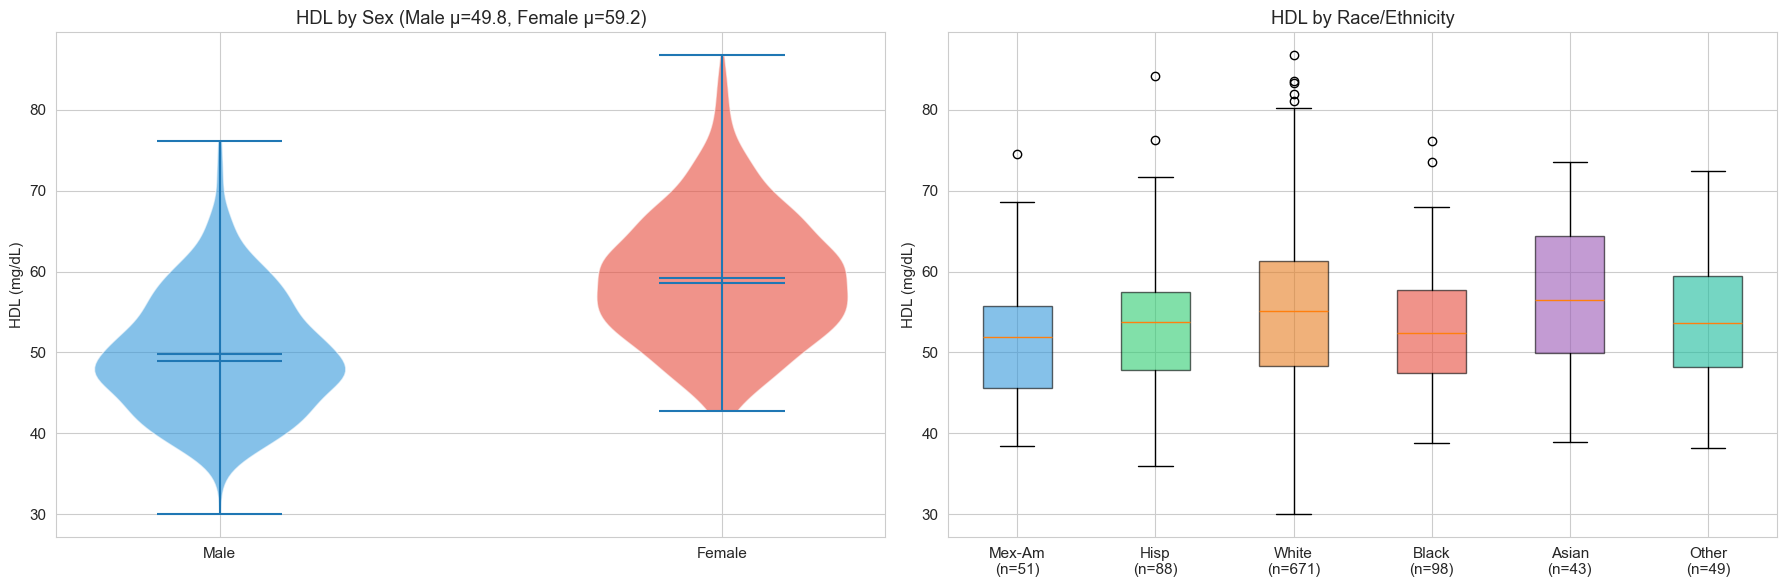

In [8]:
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# HDL by Gender
ax = axes[0]

gender_data = [
    train.loc[train['RIAGENDR'] == 1, TARGET].dropna(),
    train.loc[train['RIAGENDR'] == 2, TARGET].dropna()
]

vp = ax.violinplot(gender_data,
                   positions=[1, 2],
                   showmeans=True,
                   showmedians=True)

colors_gender = ['#3498db', '#e74c3c']
for i, body in enumerate(vp['bodies']):
    body.set_facecolor(colors_gender[i])
    body.set_alpha(0.6)

ax.set_xticks([1, 2])
ax.set_xticklabels(['Male', 'Female'])
ax.set_ylabel('HDL (mg/dL)')

m_mean = gender_data[0].mean()
f_mean = gender_data[1].mean()

ax.set_title(f'HDL by Sex (Male μ={m_mean:.1f}, Female μ={f_mean:.1f})')


# HDL by Race/Ethnicity
ax = axes[1]

if 'RIDRETH3' in train.columns:

    race_labels = {
        1: 'Mex-Am',
        2: 'Hisp',
        3: 'White',
        4: 'Black',
        6: 'Asian',
        7: 'Other'
    }

    race_groups = []
    race_names = []

    for code_val, name in sorted(race_labels.items()):
        subset = train.loc[
            train['RIDRETH3'] == code_val, TARGET
        ].dropna()

        if len(subset) > 0:
            race_groups.append(subset.values)
            race_names.append(f'{name}\n(n={len(subset)})')

    if race_groups:
        bp = ax.boxplot(race_groups,
                        labels=race_names,
                        patch_artist=True)

        colors_race = [
            '#3498db', '#2ecc71', '#e67e22',
            '#e74c3c', '#9b59b6', '#1abc9c'
        ]

        for patch, color in zip(bp['boxes'], colors_race):
            patch.set_facecolor(color)
            patch.set_alpha(0.6)

        ax.set_ylabel('HDL (mg/dL)')
        ax.set_title('HDL by Race/Ethnicity')
    else:
        ax.set_visible(False)

plt.tight_layout()
plt.show()

**Analysis — HDL by Subgroup**

The subgroup analysis shows clear differences in HDL cholesterol levels across demographic groups. The most pronounced difference is observed between sexes, where females exhibit substantially higher HDL levels (mean ≈ 59.2 mg/dL) compared to males (mean ≈ 49.8 mg/dL). The distributions also indicate a consistent upward shift in HDL values for females rather than isolated extreme observations, suggesting that sex is a strong and stable predictor in the dataset.

Across race and ethnicity groups, HDL levels display moderate variation, although distributions overlap considerably. Some groups show slightly higher median HDL values, but the within-group variability remains large relative to the differences between groups. This indicates that race/ethnicity alone is unlikely to explain HDL variation but may contribute predictive value when combined with other demographic or behavioral variables.

Overall, the subgroup analysis reinforces the multifactorial nature of HDL cholesterol, where demographic characteristics interact with body composition and lifestyle factors. From a modeling perspective, these findings support the inclusion of demographic variables and motivate the exploration of interaction effects (e.g., BMI by sex) rather than relying on subgroup variables as standalone predictors.

### B.3 Diet/Nutrient Intake vs HDL

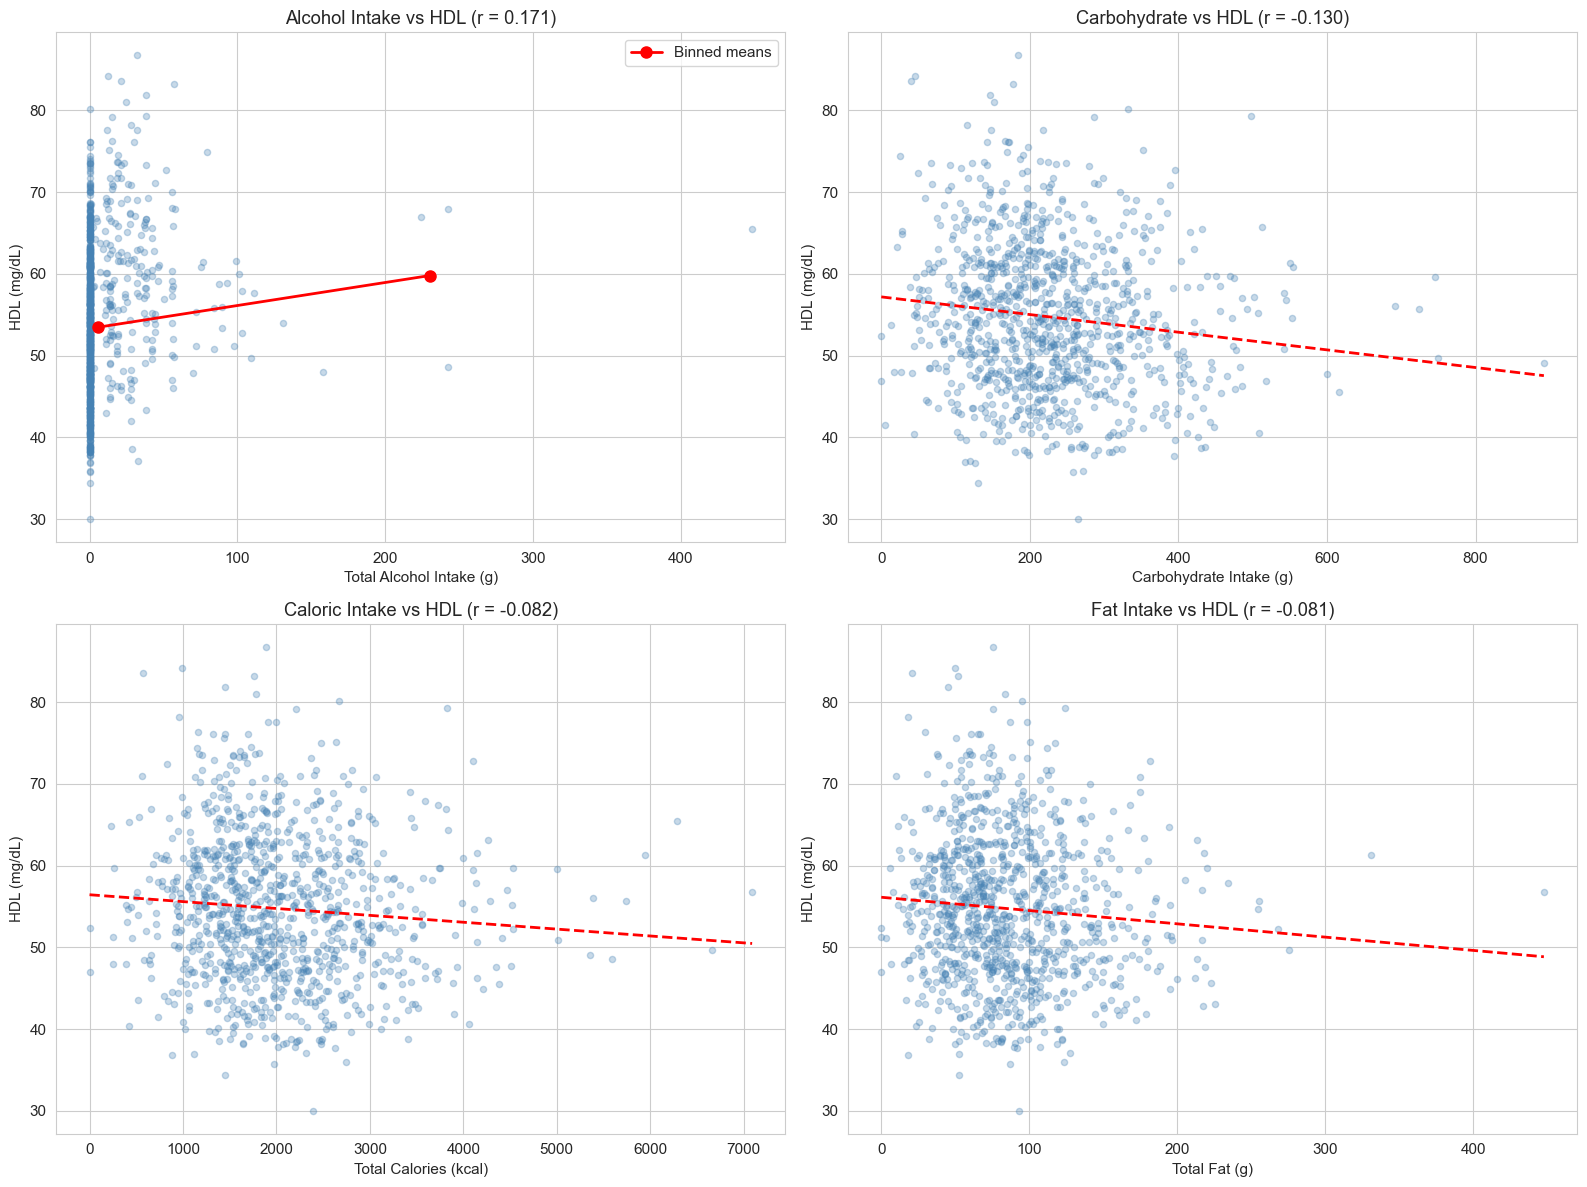

In [9]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Alcohol vs HDL
ax = axes[0, 0]
ax.scatter(train['DR1TALCO'], train[TARGET], alpha=0.3, s=20, c='steelblue')
# Binned means for alcohol
alco_bins = pd.qcut(train['DR1TALCO'], q=5, duplicates='drop')
alco_means = train.groupby(alco_bins, observed=True)[TARGET].mean()
bin_centers = [(b.left + b.right)/2 for b in alco_means.index]
ax.plot(bin_centers, alco_means.values, 'ro-', linewidth=2, markersize=8, label='Binned means')
ax.set_xlabel('Total Alcohol Intake (g)')
ax.set_ylabel('HDL (mg/dL)')
ax.set_title(f'Alcohol Intake vs HDL (r = {corr_target.get("DR1TALCO", 0):.3f})')
ax.legend()

# Total Carbohydrate vs HDL
ax = axes[0, 1]
ax.scatter(train['DR1TCARB'], train[TARGET], alpha=0.3, s=20, c='steelblue')
z = np.polyfit(train['DR1TCARB'].dropna(), train[TARGET][train['DR1TCARB'].notna()], 1)
p = np.poly1d(z)
x_line = np.linspace(train['DR1TCARB'].min(), train['DR1TCARB'].max(), 100)
ax.plot(x_line, p(x_line), 'r--', linewidth=2)
ax.set_xlabel('Carbohydrate Intake (g)')
ax.set_ylabel('HDL (mg/dL)')
ax.set_title(f'Carbohydrate vs HDL (r = {corr_target.get("DR1TCARB", 0):.3f})')

# Total Calories vs HDL
ax = axes[1, 0]
if 'DR1TKCAL' in train.columns:
    ax.scatter(train['DR1TKCAL'], train[TARGET], alpha=0.3, s=20, c='steelblue')
    z = np.polyfit(train['DR1TKCAL'].dropna(), train[TARGET][train['DR1TKCAL'].notna()], 1)
    p = np.poly1d(z)
    x_line = np.linspace(train['DR1TKCAL'].min(), train['DR1TKCAL'].max(), 100)
    ax.plot(x_line, p(x_line), 'r--', linewidth=2)
    ax.set_xlabel('Total Calories (kcal)')
    ax.set_ylabel('HDL (mg/dL)')
    ax.set_title(f'Caloric Intake vs HDL (r = {corr_target.get("DR1TKCAL", 0):.3f})')

# Total Fat vs HDL
ax = axes[1, 1]
if 'DR1TTFAT' in train.columns:
    ax.scatter(train['DR1TTFAT'], train[TARGET], alpha=0.3, s=20, c='steelblue')
    z = np.polyfit(train['DR1TTFAT'].dropna(), train[TARGET][train['DR1TTFAT'].notna()], 1)
    p = np.poly1d(z)
    x_line = np.linspace(train['DR1TTFAT'].min(), train['DR1TTFAT'].max(), 100)
    ax.plot(x_line, p(x_line), 'r--', linewidth=2)
    ax.set_xlabel('Total Fat (g)')
    ax.set_ylabel('HDL (mg/dL)')
    ax.set_title(f'Fat Intake vs HDL (r = {corr_target.get("DR1TTFAT", 0):.3f})')

plt.tight_layout()
plt.show()

**Analysis — Diet/Nutrient Intake vs HDL**

The relationship between dietary intake variables and HDL cholesterol appears generally weak when evaluated individually. Alcohol intake shows a small positive association with HDL levels (r = 0.171), with binned averages suggesting a mild upward trend at higher intake levels. However, the large dispersion of observations indicates substantial variability, suggesting that alcohol consumption alone is not a strong predictor.

Carbohydrate intake exhibits a slight negative relationship with HDL (r = -0.130), while total caloric intake and total fat intake show very weak negative correlations (r ≈ -0.08). The wide spread of observations across all intake levels indicates that total macronutrient consumption does not explain HDL variability in isolation.

These findings are consistent with the expectation that dietary effects on HDL are complex and likely mediated through interactions with body composition, lifestyle factors, and overall dietary patterns rather than single nutrient quantities. From a modeling perspective, this suggests that raw intake variables may contribute limited linear predictive power but could become more informative through feature engineering approaches such as ratios (e.g., macronutrient composition), normalization by total caloric intake, or interaction terms with demographic and behavioral variables.

Overall, the analysis supports the inclusion of dietary variables while reinforcing the need for models capable of capturing non-linear relationships and interactions among predictors.

### B.4 Waist Circumference vs HDL

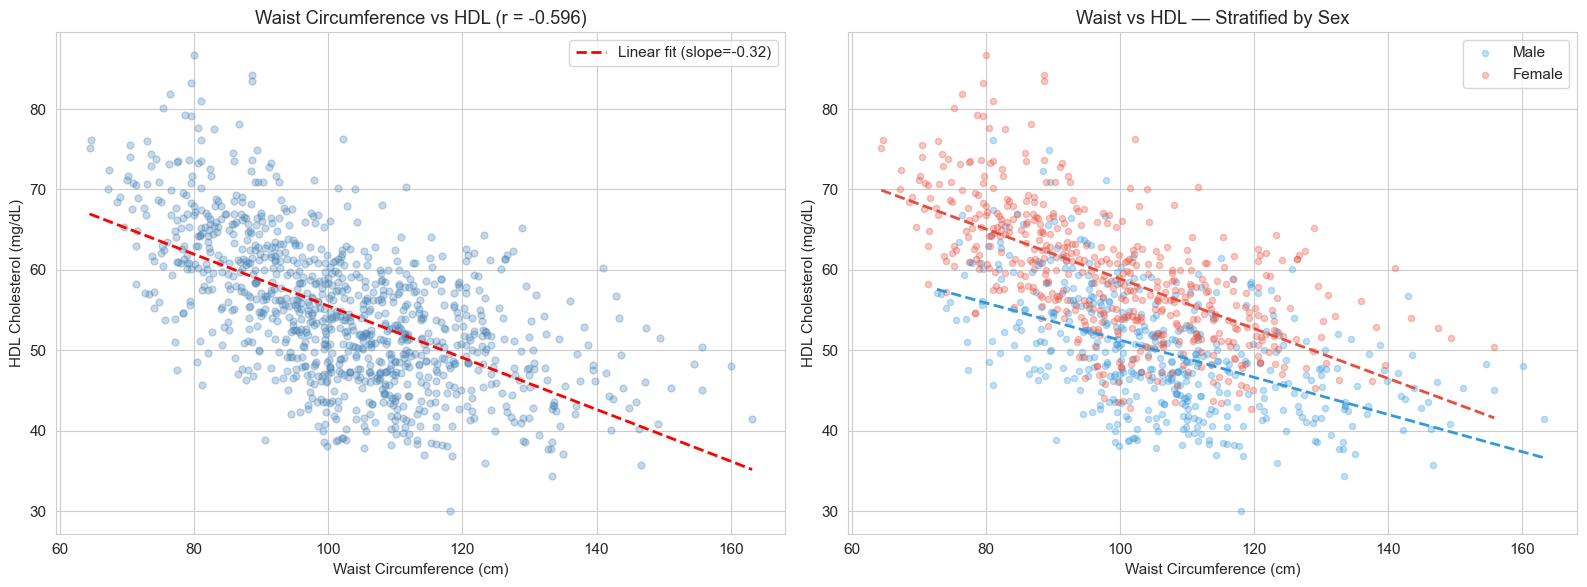

In [10]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Scatter + trend line
ax = axes[0]
ax.scatter(train['BMXWAIST'], train[TARGET], alpha=0.3, s=25, c='steelblue')
z = np.polyfit(train['BMXWAIST'].dropna(), train[TARGET][train['BMXWAIST'].notna()], 1)
p = np.poly1d(z)
x_line = np.linspace(train['BMXWAIST'].min(), train['BMXWAIST'].max(), 100)
ax.plot(x_line, p(x_line), 'r--', linewidth=2, label=f'Linear fit (slope={z[0]:.2f})')
ax.set_xlabel('Waist Circumference (cm)')
ax.set_ylabel('HDL Cholesterol (mg/dL)')
ax.set_title(f'Waist Circumference vs HDL (r = {corr_target.get("BMXWAIST", 0):.3f})')
ax.legend()

# Stratified by sex
ax = axes[1]
for sex, color, label in [(1, '#3498db', 'Male'), (2, '#e74c3c', 'Female')]:
    mask = train['RIAGENDR'] == sex
    ax.scatter(train.loc[mask, 'BMXWAIST'], train.loc[mask, TARGET],
              alpha=0.3, s=20, c=color, label=label)
    z = np.polyfit(train.loc[mask, 'BMXWAIST'], train.loc[mask, TARGET], 1)
    p = np.poly1d(z)
    x_line = np.linspace(train.loc[mask, 'BMXWAIST'].min(), train.loc[mask, 'BMXWAIST'].max(), 100)
    ax.plot(x_line, p(x_line), color=color, linestyle='--', linewidth=2)
ax.set_xlabel('Waist Circumference (cm)')
ax.set_ylabel('HDL Cholesterol (mg/dL)')
ax.set_title('Waist vs HDL — Stratified by Sex')
ax.legend()

plt.tight_layout()
plt.show()

**Analysis — Waist Circumference vs HDL**

Waist circumference shows the strongest relationship with HDL cholesterol among the variables analyzed, with a clear negative association (r = -0.596). The scatter plot demonstrates a consistent downward trend, indicating that larger waist measurements are associated with lower HDL levels. Compared to BMI, waist circumference appears to capture body composition effects more strongly, suggesting that central adiposity may be a more informative predictor of HDL variation.

The stratified analysis by sex reveals that this negative relationship holds for both males and females, although females consistently exhibit higher HDL levels across most waist circumference ranges. The approximately parallel trends suggest that sex shifts the overall HDL level rather than fundamentally altering the relationship between waist circumference and HDL.

Despite the strong association, considerable variability remains around the trend line, indicating that waist circumference alone does not fully explain HDL variability. This reinforces the multifactorial nature of HDL regulation and supports the inclusion of additional demographic, behavioral, and dietary variables in the predictive models.

From a modeling perspective, waist circumference is expected to be a highly informative feature. The observed patterns also motivate potential interaction terms (e.g., waist circumference by sex) and support the use of models capable of capturing non-linear effects and interactions among predictors.

### B.5 Age vs HDL

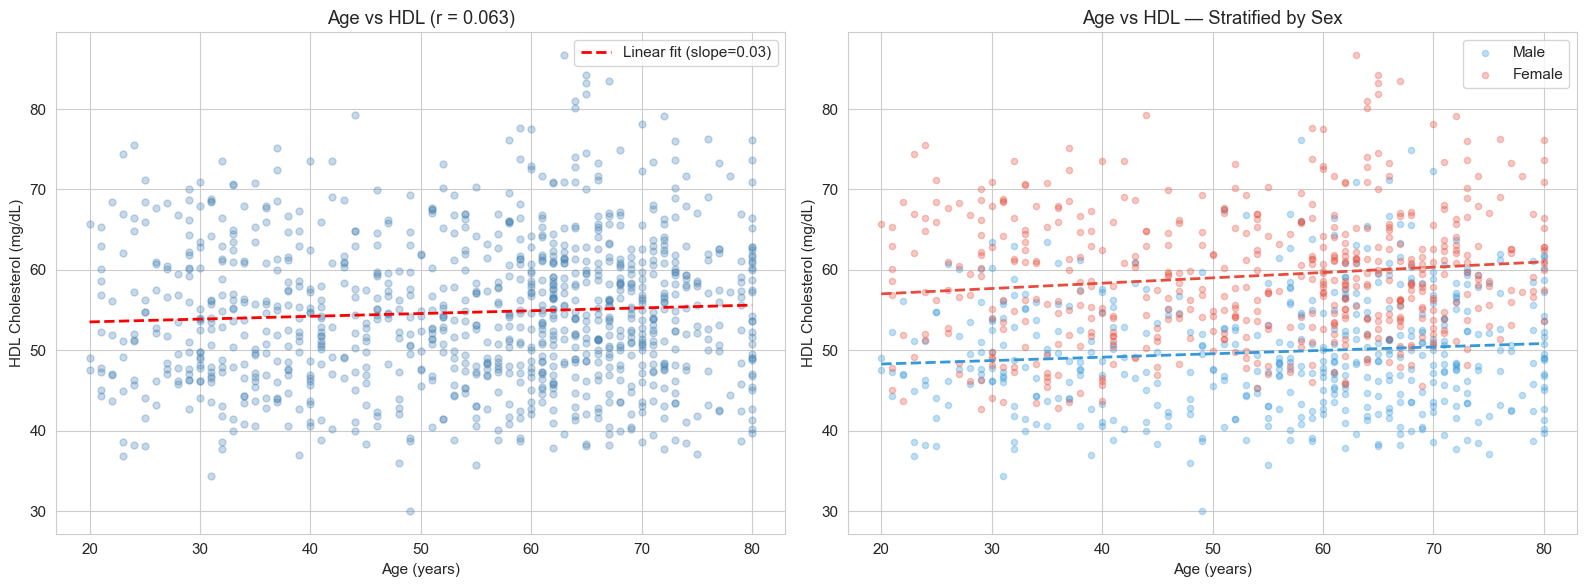

In [11]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

ax = axes[0]
ax.scatter(train['RIDAGEYR'], train[TARGET], alpha=0.3, s=25, c='steelblue')
z = np.polyfit(train['RIDAGEYR'].dropna(), train[TARGET][train['RIDAGEYR'].notna()], 1)
p = np.poly1d(z)
x_line = np.linspace(train['RIDAGEYR'].min(), train['RIDAGEYR'].max(), 100)
ax.plot(x_line, p(x_line), 'r--', linewidth=2, label=f'Linear fit (slope={z[0]:.2f})')
ax.set_xlabel('Age (years)')
ax.set_ylabel('HDL Cholesterol (mg/dL)')
ax.set_title(f'Age vs HDL (r = {corr_target.get("RIDAGEYR", 0):.3f})')
ax.legend()

ax = axes[1]
for sex, color, label in [(1, '#3498db', 'Male'), (2, '#e74c3c', 'Female')]:
    mask = train['RIAGENDR'] == sex
    ax.scatter(train.loc[mask, 'RIDAGEYR'], train.loc[mask, TARGET],
              alpha=0.3, s=20, c=color, label=label)
    z = np.polyfit(train.loc[mask, 'RIDAGEYR'], train.loc[mask, TARGET], 1)
    p = np.poly1d(z)
    x_line = np.linspace(train.loc[mask, 'RIDAGEYR'].min(), train.loc[mask, 'RIDAGEYR'].max(), 100)
    ax.plot(x_line, p(x_line), color=color, linestyle='--', linewidth=2)
ax.set_xlabel('Age (years)')
ax.set_ylabel('HDL Cholesterol (mg/dL)')
ax.set_title('Age vs HDL — Stratified by Sex')
ax.legend()

plt.tight_layout()
plt.show()

**Analysis — Age vs HDL**

The relationship between age and HDL cholesterol appears weak, with only a slight positive association observed (r = 0.063). The scatter plot shows a broad dispersion of HDL values across all age groups, indicating that age alone explains little of the variability in HDL levels.

When stratified by sex, a consistent upward trend with age is observed for both males and females, although females maintain higher HDL levels across nearly all age ranges. The approximately parallel trends suggest that age contributes modestly to HDL variation while sex primarily shifts the overall HDL level rather than altering the age-HDL relationship itself.

The weak linear association suggests that age is unlikely to be a strong standalone predictor but may still provide incremental predictive value when combined with body composition or lifestyle variables. From a modeling perspective, this supports retaining age as a feature while allowing models capable of capturing interactions or mild non-linear effects to determine its contribution.

Overall, the analysis reinforces earlier findings that HDL cholesterol is influenced more strongly by body composition measures than by age alone.

## Key Findings from Exploratory Data Analysis

The exploratory analysis reveals several important patterns that guide feature engineering and model selection:

- **Body composition is the strongest predictor of HDL levels.** Waist circumference shows the strongest negative relationship with HDL, followed by BMI, indicating that central adiposity plays a major role in HDL variability.

- **Sex differences are substantial and consistent.** Females exhibit systematically higher HDL levels across nearly all ranges of age and body composition, suggesting that demographic effects primarily shift HDL levels rather than altering underlying relationships.

- **Dietary variables show weak individual relationships.** Alcohol intake shows a mild positive association with HDL, while carbohydrate, fat, and total caloric intake demonstrate only weak linear relationships. This suggests that dietary effects may operate through interactions or relative composition rather than absolute intake levels.

- **Age has limited standalone predictive power.** Although HDL increases slightly with age, the effect size is small compared to body composition variables, indicating that age contributes mainly in combination with other features.

- **HDL variation appears multifactorial and moderately non-linear.** No single variable fully explains HDL variability, supporting the use of models capable of capturing interactions and non-linear relationships, such as tree-based ensemble methods or neural networks.

Overall, the EDA suggests prioritizing body composition features, incorporating demographic interactions, and allowing flexible models to capture complex relationships among predictors.

---
## Task C — Predictive Analysis

### C.1 Feature Engineering

Custom transformer that creates clinically-motivated interaction terms, polynomial features, and log transforms. All thresholds computed in `fit()` on training data only to prevent data leakage.

In [12]:
class FeatureEngineer(BaseEstimator, TransformerMixin):
    """Leakage-safe feature engineering for HDL prediction."""

    def fit(self, X, y=None):
        self.log_cols_ = []
        numeric_cols = X.select_dtypes(include=[np.number]).columns
        for col in numeric_cols:
            if X[col].min() > 0 and X[col].skew() > 2:
                self.log_cols_.append(col)
        
        # Admin/weak features + features with negative permutation importance
        self.drop_cols_ = [
            # Admin
            'DR1EXMER', 'WTDR2D',
            # Original weak (|r| < 0.02)
            'DR1_300', 'DR1_330Z', 'DR1HELP',
            'DR1TS060', 'DR1TS100', 'DR1STY', 'DR1TP184', 'DR1TFDFE',
            # Permutation importance <= 0 (both models say useless)
            'DR1TLYCO', 'DR1TBCAR', 'DRQSPREP', 'DR1TACAR', 'DR1TCHL',
            'DR1TP226', 'DR1TMAGN', 'DR1TCRYP', 'DR1TZINC', 'DR1TFF',
            'DR1TIRON', 'DR1TFOLA', 'DR1TNIAC', 'DBQ095Z', 'DR1TM221',
            'DR1TVB12', 'DR1DAY', 'DR1TVD', 'DR1TM201',
            'DRQSDIET', 'DR1TTHEO', 'DR1TCHOL', 'DMDMARTZ',
            'DRD340', 'ALQ111', 'DRABF', 'DR1MRESP',
        ]
        
        # Log cols that ended up harmful — exclude from log transform
        self.bad_log_cols_ = ['DMDMARTZ_log', 'DRD360_log', 'DR1LANG_log']
        
        self.fitted_ = True
        return self

    def transform(self, X):
        X = X.copy()
        for col in self.drop_cols_:
            if col in X.columns:
                X = X.drop(columns=[col])

        # Interactions (sex x body composition + lifestyle)
        if 'BMXWAIST' in X.columns and 'RIAGENDR' in X.columns:
            X['Waist_x_Sex'] = X['BMXWAIST'] * X['RIAGENDR']
        if 'BMXBMI' in X.columns and 'RIAGENDR' in X.columns:
            X['BMI_x_Sex'] = X['BMXBMI'] * X['RIAGENDR']
        if 'RIDAGEYR' in X.columns and 'RIAGENDR' in X.columns:
            X['Age_x_Sex'] = X['RIDAGEYR'] * X['RIAGENDR']
        if 'BMXWAIST' in X.columns and 'RIDAGEYR' in X.columns:
            X['Age_x_Waist'] = X['RIDAGEYR'] * X['BMXWAIST']
        if 'BMXWAIST' in X.columns and 'BMXBMI' in X.columns:
            X['Waist_x_BMI'] = X['BMXWAIST'] * X['BMXBMI']
        if 'DR1TALCO' in X.columns and 'RIAGENDR' in X.columns:
            X['Alcohol_x_Sex'] = X['DR1TALCO'] * X['RIAGENDR']
        if 'RIDRETH3' in X.columns and 'RIAGENDR' in X.columns:
            X['Race_x_Sex'] = X['RIDRETH3'] * X['RIAGENDR']
        if 'ALQ121' in X.columns and 'DR1TALCO' in X.columns:
            X['Alcohol_Freq_x_Amount'] = X['ALQ121'] * X['DR1TALCO']
        if 'INDFMPIR' in X.columns and 'RIAGENDR' in X.columns:
            X['Income_x_Sex'] = X['INDFMPIR'] * X['RIAGENDR']
        if 'DR1TNUMF' in X.columns and 'RIAGENDR' in X.columns:
            X['FoodDiv_x_Sex'] = X['DR1TNUMF'] * X['RIAGENDR']
        if 'DRD360' in X.columns and 'RIAGENDR' in X.columns:
            X['Fish_x_Sex'] = X['DRD360'] * X['RIAGENDR']

        # Ratios (removed Waist_to_BMI — negative perm importance)
        if 'BMXWAIST' in X.columns and 'BMXHT' in X.columns:
            X['Waist_to_Height'] = X['BMXWAIST'] / (X['BMXHT'] + 1e-6)
        if 'BMXWT' in X.columns and 'BMXHT' in X.columns:
            X['Weight_to_Height'] = X['BMXWT'] / (X['BMXHT'] + 1e-6)

        # Polynomials
        if 'BMXWAIST' in X.columns:
            X['Waist_Sq'] = X['BMXWAIST'] ** 2
        if 'BMXBMI' in X.columns:
            X['BMI_Sq'] = X['BMXBMI'] ** 2
        if 'RIDAGEYR' in X.columns:
            X['Age_Sq'] = X['RIDAGEYR'] ** 2

        # Removed: High_Waist, Is_Obese (negative perm importance)

        # Log transforms (excluding harmful ones)
        for col in self.log_cols_:
            if col in X.columns:
                log_name = col + '_log'
                if log_name not in self.bad_log_cols_:
                    X[log_name] = np.log1p(X[col].clip(lower=0))

        X = X.select_dtypes(include=[np.number])
        return X

# Verify
fe = FeatureEngineer()
fe.fit(X_full)
X_transformed = fe.transform(X_full)
print(f"Features before engineering: {X_full.shape[1]}")
print(f"Features after engineering:  {X_transformed.shape[1]}")
print(f"\nEngineered features:")
for f in [c for c in X_transformed.columns if c not in X_full.columns]:
    print(f"  + {f}")

Features before engineering: 95
Features after engineering:  73

Engineered features:
  + Waist_x_Sex
  + BMI_x_Sex
  + Age_x_Sex
  + Age_x_Waist
  + Waist_x_BMI
  + Alcohol_x_Sex
  + Race_x_Sex
  + Alcohol_Freq_x_Amount
  + Income_x_Sex
  + FoodDiv_x_Sex
  + Fish_x_Sex
  + Waist_Sq
  + BMI_Sq
  + Age_Sq
  + DR1TWSZ_log


**Analysis — Feature Engineering**

Feature engineering was guided by findings from the exploratory data analysis (EDA) and subsequent model diagnostics, with the objective of capturing non-linear effects and interaction patterns while reducing noise and preventing data leakage.

Body composition variables emerged as the strongest predictors of HDL levels during EDA, particularly waist circumference and BMI. Consistent with this observation, several engineered features were derived from these variables to capture non-linear physiological relationships. Squared terms for waist circumference, BMI, and age were introduced to allow models to learn curvature effects, reflecting the fact that metabolic outcomes often do not change linearly across body composition ranges. Interaction terms such as waist × BMI and age × waist further capture combined body composition effects that may influence HDL beyond individual measurements.

Interaction terms involving sex were incorporated to account for systematic biological and behavioral differences across demographic groups. Variables such as age × sex, alcohol consumption × sex, income × sex, and food diversity × sex allow the model to capture heterogeneous effects that may differ between males and females. Several of these interaction terms demonstrated stronger predictive relevance than their original variables, suggesting that demographic effects operate through interaction mechanisms rather than purely additive relationships.

Ratio-based transformations, including waist-to-height and weight-to-height, were introduced to represent relative body composition instead of absolute size. These features help normalize anthropometric measurements and improve comparability across individuals with different body frames, which is particularly relevant in metabolic prediction tasks.

In addition to feature creation, a systematic feature reduction step was applied. Administrative variables, weak predictors identified during EDA, and features with non-positive permutation importance across models were removed. This step reduced dimensionality and mitigated the risk of overfitting by eliminating variables that introduced noise without improving predictive performance.

Finally, logarithmic transformations were selectively applied to highly skewed positive variables in order to reduce the influence of extreme values and stabilize variance. Log transformations that negatively affected model performance were explicitly excluded, ensuring that transformations were retained only when empirically beneficial.

Overall, the feature engineering process balances interpretability, physiological plausibility, and predictive performance. The resulting feature set emphasizes body composition dynamics and demographic interactions while removing redundant or low-value predictors, leading to a more compact and informative representation for downstream modeling.

### C.2 Training Configuration (Full Training Set)

In [13]:
# For final submission: train on ALL data (no validation split)
X_train = X_full
y_train = y_full

print(f"Training set: {X_train.shape[0]} rows (full training data)")
print(f"Test set:     {X_test.shape[0]} rows")
print(f"\nTarget distribution:")
print(f"  Train — mean: {y_train.mean():.2f}, std: {y_train.std():.2f}")


Training set: 1000 rows (full training data)
Test set:     200 rows

Target distribution:
  Train — mean: 54.73, std: 9.01


**Analysis — Training Configuration**

For the final competition submission, the entire training dataset (1,000 observations) was used for model training without a held-out validation split. This approach maximizes the amount of information available to each model, which is particularly beneficial for a relatively small dataset where every observation contributes to learning the underlying signal.

The target variable has a mean of 54.73 mg/dL and a standard deviation of 9.01, consistent with the distributional characteristics observed during exploratory data analysis. Model performance estimates are obtained exclusively through 5-fold cross-validation, which provides reliable out-of-sample error estimates while allowing all data to be used for final model fitting. Cross-validated out-of-fold predictions are used for residual analysis and model comparison.

This strategy differs from the midterm analysis, where an 80/20 train/validation split was used for model selection. Since the model architecture and hyperparameters have already been validated in the previous phase, the submission phase prioritizes maximizing training data to improve final prediction accuracy on the unseen test set.

### C.3 Baseline — Elastic Net (Linear Model)

In [14]:
def make_pipeline(model):
    return Pipeline([
        ('features', FeatureEngineer()),
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', RobustScaler()),
        ('model', model),
    ])

# Elastic Net with GridSearchCV
enet_pipeline = make_pipeline(ElasticNet(max_iter=10000, random_state=SEED))

enet_params = {
    'model__alpha': [0.01, 0.1, 1, 10, 100],
    'model__l1_ratio': [0.1, 0.5, 0.7, 0.9, 1.0],
}

cv = KFold(n_splits=5, shuffle=True, random_state=SEED)
enet_grid = GridSearchCV(
    enet_pipeline, enet_params, cv=cv,
    scoring='neg_root_mean_squared_error', n_jobs=-1, refit=True
)
enet_grid.fit(X_train, y_train)

enet_cv_rmse = -enet_grid.best_score_

print(f"Elastic Net Results:")
print(f"  Best params: {enet_grid.best_params_}")
print(f"  CV RMSE:  {enet_cv_rmse:.4f}")


Elastic Net Results:
  Best params: {'model__alpha': 0.01, 'model__l1_ratio': 1.0}
  CV RMSE:  5.4302


**Analysis — Elastic Net Results**

The Elastic Net model serves as the linear baseline for this prediction task. The optimal configuration selected through cross-validation corresponds to an L1 ratio of 1.0, effectively reducing the model to a Lasso regression. This indicates that feature sparsity improves predictive performance, suggesting that only a subset of the available features contributes meaningfully to explaining HDL variability.

The cross-validation RMSE of **5.4302** confirms that a significant portion of HDL variation can be explained through approximately linear relationships, particularly those related to body composition and demographic variables identified during the exploratory analysis. However, the remaining prediction error suggests that non-linear effects and interaction patterns are likely present. Therefore, further improvements are expected from more flexible models such as tree-based ensemble methods and neural networks.

Overall, Elastic Net provides a strong and interpretable benchmark against which more complex models can be evaluated.

### C.4 Tree Ensemble Models

GridSearchCV with 5-fold cross-validation for Random Forest, XGBoost, LightGBM, and CatBoost. Grids are tightened around best parameters found in previous experiments.

In [15]:
import optuna
optuna.logging.set_verbosity(optuna.logging.WARNING)

from sklearn.model_selection import cross_val_score

# CatBoost
def objective_cat(trial):
    params = {
        'iterations': trial.suggest_int('iterations', 500, 2500),
        'depth': trial.suggest_int('depth', 3, 8),
        'learning_rate': trial.suggest_float('learning_rate', 0.003, 0.05, log=True),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 0.01, 10, log=True),
        'random_strength': trial.suggest_float('random_strength', 0.1, 5),
        'bagging_temperature': trial.suggest_float('bagging_temperature', 0, 3),
        'border_count': trial.suggest_int('border_count', 32, 255),
    }
    pipe = make_pipeline(CatBoostRegressor(verbose=0, random_state=SEED, **params))
    cv = KFold(n_splits=5, shuffle=True, random_state=SEED)
    scores = cross_val_score(pipe, X_train, y_train, cv=cv,
                            scoring='neg_root_mean_squared_error')
    return -scores.mean()

print("Optimizing CatBoost...")
study_cat = optuna.create_study(direction='minimize')
study_cat.optimize(objective_cat, n_trials=200, show_progress_bar=True)
print(f"  Best CV RMSE: {study_cat.best_value:.4f}")
print(f"  Best params: {study_cat.best_params}")

# XGBoost
def objective_xgb(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 300, 2500),
        'max_depth': trial.suggest_int('max_depth', 3, 8),
        'learning_rate': trial.suggest_float('learning_rate', 0.003, 0.05, log=True),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.4, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.001, 10, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.001, 10, log=True),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
    }
    pipe = make_pipeline(XGBRegressor(verbosity=0, random_state=SEED, **params))
    cv = KFold(n_splits=5, shuffle=True, random_state=SEED)
    scores = cross_val_score(pipe, X_train, y_train, cv=cv,
                            scoring='neg_root_mean_squared_error')
    return -scores.mean()

print("\nOptimizing XGBoost...")
study_xgb = optuna.create_study(direction='minimize')
study_xgb.optimize(objective_xgb, n_trials=200, show_progress_bar=True)
print(f"  Best CV RMSE: {study_xgb.best_value:.4f}")
print(f"  Best params: {study_xgb.best_params}")

# LightGBM — rangos más chicos y menos trials
def objective_lgb(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 300, 1500),
        'max_depth': trial.suggest_int('max_depth', 3, 8),
        'learning_rate': trial.suggest_float('learning_rate', 0.005, 0.05, log=True),
        'num_leaves': trial.suggest_int('num_leaves', 15, 63),
        'subsample': trial.suggest_float('subsample', 0.7, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.001, 5, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.001, 5, log=True),
        'min_child_samples': trial.suggest_int('min_child_samples', 10, 50),
    }
    pipe = make_pipeline(LGBMRegressor(verbose=-1, random_state=SEED, **params))
    cv = KFold(n_splits=5, shuffle=True, random_state=SEED)
    scores = cross_val_score(pipe, X_train, y_train, cv=cv,
                            scoring='neg_root_mean_squared_error')
    return -scores.mean()

print("\nOptimizing LightGBM...")
study_lgb = optuna.create_study(direction='minimize')
study_lgb.optimize(objective_lgb, n_trials=100, show_progress_bar=True)
print(f"  Best CV RMSE: {study_lgb.best_value:.4f}")
print(f"  Best params: {study_lgb.best_params}")

# Summary
print(f"\n{'='*50}")
print(f"SUMMARY OPTUNA")
print(f"{'='*50}")
print(f"  CatBoost  CV RMSE: {study_cat.best_value:.4f}")
print(f"  XGBoost   CV RMSE: {study_xgb.best_value:.4f}")
print(f"  LightGBM  CV RMSE: {study_lgb.best_value:.4f}")

Optimizing CatBoost...


  0%|          | 0/200 [00:00<?, ?it/s]

  Best CV RMSE: 4.5307
  Best params: {'iterations': 1596, 'depth': 6, 'learning_rate': 0.009805183751253223, 'l2_leaf_reg': 0.09223611865399252, 'random_strength': 0.42393645740006236, 'bagging_temperature': 2.6715870160224533, 'border_count': 60}

Optimizing XGBoost...


  0%|          | 0/200 [00:00<?, ?it/s]

  Best CV RMSE: 4.5833
  Best params: {'n_estimators': 1969, 'max_depth': 4, 'learning_rate': 0.003998823604043025, 'subsample': 0.6809513249884157, 'colsample_bytree': 0.5235060935338892, 'reg_alpha': 4.475607205078161, 'reg_lambda': 0.7714822394490476, 'min_child_weight': 6}

Optimizing LightGBM...


  0%|          | 0/100 [00:00<?, ?it/s]

  Best CV RMSE: 4.6199
  Best params: {'n_estimators': 439, 'max_depth': 6, 'learning_rate': 0.03195923916516681, 'num_leaves': 24, 'subsample': 0.901971201222344, 'colsample_bytree': 0.5153358806802573, 'reg_alpha': 0.44220290383547917, 'reg_lambda': 0.01940264638417126, 'min_child_samples': 45}

SUMMARY OPTUNA
  CatBoost  CV RMSE: 4.5307
  XGBoost   CV RMSE: 4.5833
  LightGBM  CV RMSE: 4.6199


In [16]:
from sklearn.model_selection import cross_val_predict

# Save Optuna results in tree_results
optuna_models = {
    'CatBoost': {
        'study': study_cat,
        'model_class': CatBoostRegressor,
        'extra': {'verbose': 0, 'random_state': SEED},
    },
    'XGBoost': {
        'study': study_xgb,
        'model_class': XGBRegressor,
        'extra': {'verbosity': 0, 'random_state': SEED},
    },
    'LightGBM': {
        'study': study_lgb,
        'model_class': LGBMRegressor,
        'extra': {'verbose': -1, 'random_state': SEED},
    },
}

tree_results = {}
cv = KFold(n_splits=5, shuffle=True, random_state=SEED)

for model_name, cfg in optuna_models.items():
    best_params = {**cfg['study'].best_params, **cfg['extra']}
    pipe = make_pipeline(cfg['model_class'](**best_params))

    # Get out-of-fold predictions for residual analysis
    cv_pred = cross_val_predict(pipe, X_train, y_train, cv=cv)
    cv_rmse = np.sqrt(mean_squared_error(y_train, cv_pred))
    cv_mae = mean_absolute_error(y_train, cv_pred)
    cv_r2 = r2_score(y_train, cv_pred)

    # Fit on all training data
    pipe.fit(X_train, y_train)

    tree_results[model_name] = {
        'grid': pipe,
        'cv_rmse': cv_rmse,
        'cv_mae': cv_mae,
        'cv_r2': cv_r2,
        'cv_pred': cv_pred,
        'best_params': cfg['study'].best_params,
    }

    print(f"\n{model_name}:")
    print(f"  Best params: {cfg['study'].best_params}")
    print(f"  CV RMSE: {cv_rmse:.4f}")
    print(f"  CV MAE:  {cv_mae:.4f}")
    print(f"  CV R²:   {cv_r2:.4f}")



CatBoost:
  Best params: {'iterations': 1596, 'depth': 6, 'learning_rate': 0.009805183751253223, 'l2_leaf_reg': 0.09223611865399252, 'random_strength': 0.42393645740006236, 'bagging_temperature': 2.6715870160224533, 'border_count': 60}
  CV RMSE: 4.5339
  CV MAE:  3.6680
  CV R²:   0.7466

XGBoost:
  Best params: {'n_estimators': 1969, 'max_depth': 4, 'learning_rate': 0.003998823604043025, 'subsample': 0.6809513249884157, 'colsample_bytree': 0.5235060935338892, 'reg_alpha': 4.475607205078161, 'reg_lambda': 0.7714822394490476, 'min_child_weight': 6}
  CV RMSE: 4.5869
  CV MAE:  3.7059
  CV R²:   0.7406

LightGBM:
  Best params: {'n_estimators': 439, 'max_depth': 6, 'learning_rate': 0.03195923916516681, 'num_leaves': 24, 'subsample': 0.901971201222344, 'colsample_bytree': 0.5153358806802573, 'reg_alpha': 0.44220290383547917, 'reg_lambda': 0.01940264638417126, 'min_child_samples': 45}
  CV RMSE: 4.6255
  CV MAE:  3.7123
  CV R²:   0.7362


In [17]:
from sklearn.linear_model import Ridge
from sklearn.ensemble import StackingRegressor
from sklearn.model_selection import cross_val_score

# Stacking 2 modelos (CatBoost + XGBoost)
stacking_2 = StackingRegressor(
    estimators=[
        ('cat', tree_results['CatBoost']['grid']),
        ('xgb', tree_results['XGBoost']['grid']),
    ],
    final_estimator=Ridge(alpha=10),
    cv=5
)

# CV predictions for residual analysis
stack2_cv_pred = cross_val_predict(stacking_2, X_train, y_train, cv=cv)
stack2_cv_rmse = np.sqrt(mean_squared_error(y_train, stack2_cv_pred))
stack2_cv_mae = mean_absolute_error(y_train, stack2_cv_pred)
stack2_cv_r2 = r2_score(y_train, stack2_cv_pred)
stacking_2.fit(X_train, y_train)

print(f"Stacking 2 (Cat + XGB):")
print(f"  CV RMSE: {stack2_cv_rmse:.4f}")
print(f"  CV MAE:  {stack2_cv_mae:.4f}")
print(f"  CV R²:   {stack2_cv_r2:.4f}")

# Stacking 3 modelos
stacking_3 = StackingRegressor(
    estimators=[
        ('cat', tree_results['CatBoost']['grid']),
        ('xgb', tree_results['XGBoost']['grid']),
        ('lgb', tree_results['LightGBM']['grid']),
    ],
    final_estimator=Ridge(alpha=10),
    cv=5
)

stack3_cv_pred = cross_val_predict(stacking_3, X_train, y_train, cv=cv)
stack3_cv_rmse = np.sqrt(mean_squared_error(y_train, stack3_cv_pred))
stack3_cv_mae = mean_absolute_error(y_train, stack3_cv_pred)
stack3_cv_r2 = r2_score(y_train, stack3_cv_pred)
stacking_3.fit(X_train, y_train)

print(f"\nStacking 3 (Cat + XGB + LGB):")
print(f"  CV RMSE: {stack3_cv_rmse:.4f}")
print(f"  CV MAE:  {stack3_cv_mae:.4f}")
print(f"  CV R²:   {stack3_cv_r2:.4f}")

print(f"\nDifference: {stack2_cv_rmse - stack3_cv_rmse:+.4f} (negative = 2 models is better)")


Stacking 2 (Cat + XGB):
  CV RMSE: 4.5394
  CV MAE:  3.6698
  CV R²:   0.7460

Stacking 3 (Cat + XGB + LGB):
  CV RMSE: 4.5510
  CV MAE:  3.6774
  CV R²:   0.7446

Difference: -0.0116 (negative = 2 models is better)


In [18]:
tree_results['Stacking_2'] = {
    'grid': stacking_2,
    'cv_rmse': stack2_cv_rmse, 'cv_mae': stack2_cv_mae, 'cv_r2': stack2_cv_r2,
    'cv_pred': stack2_cv_pred,
}
tree_results['Stacking_3'] = {
    'grid': stacking_3,
    'cv_rmse': stack3_cv_rmse, 'cv_mae': stack3_cv_mae, 'cv_r2': stack3_cv_r2,
    'cv_pred': stack3_cv_pred,
}

In [19]:
from scipy.optimize import minimize

# Get out-of-fold predictions from each model
cat_oof = tree_results['CatBoost']['cv_pred']
xgb_oof = tree_results['XGBoost']['cv_pred']
lgb_oof = tree_results['LightGBM']['cv_pred']

def blend_rmse(weights):
    w = weights / weights.sum()  # normalize
    blended = w[0]*cat_oof + w[1]*xgb_oof + w[2]*lgb_oof
    return np.sqrt(mean_squared_error(y_train, blended))

# Optimize weights
result = minimize(blend_rmse, x0=[1/3, 1/3, 1/3], 
                  method='Nelder-Mead',
                  bounds=[(0,1)]*3)
best_w = result.x / result.x.sum()

print(f"Optimal weights:")
print(f"  CatBoost:  {best_w[0]:.3f}")
print(f"  XGBoost:   {best_w[1]:.3f}")
print(f"  LightGBM:  {best_w[2]:.3f}")
print(f"\nWeighted Blend CV RMSE: {result.fun:.4f}")
print(f"Stacking_3 CV RMSE:    {tree_results['Stacking_3']['cv_rmse']:.4f}")
print(f"Difference:            {result.fun - tree_results['Stacking_3']['cv_rmse']:+.4f}")

# Generate test predictions with optimal weights
cat_test = tree_results['CatBoost']['grid'].predict(X_test)
xgb_test = tree_results['XGBoost']['grid'].predict(X_test)
lgb_test = tree_results['LightGBM']['grid'].predict(X_test)

blend_test_pred = best_w[0]*cat_test + best_w[1]*xgb_test + best_w[2]*lgb_test
print(f"\nBlend Test Predictions: mean={blend_test_pred.mean():.2f}, std={blend_test_pred.std():.2f}")

Optimal weights:
  CatBoost:  0.768
  XGBoost:   0.000
  LightGBM:  0.232

Weighted Blend CV RMSE: 4.5245
Stacking_3 CV RMSE:    4.5510
Difference:            -0.0265

Blend Test Predictions: mean=54.41, std=7.61


In [20]:
for name, res in tree_results.items():
    print(f"\n{name}:")
    print(f"  CV RMSE: {res['cv_rmse']:.4f}")
    print(f"  CV MAE:  {res['cv_mae']:.4f}")
    print(f"  CV R²:   {res['cv_r2']:.4f}")



CatBoost:
  CV RMSE: 4.5339
  CV MAE:  3.6680
  CV R²:   0.7466

XGBoost:
  CV RMSE: 4.5869
  CV MAE:  3.7059
  CV R²:   0.7406

LightGBM:
  CV RMSE: 4.6255
  CV MAE:  3.7123
  CV R²:   0.7362

Stacking_2:
  CV RMSE: 4.5394
  CV MAE:  3.6698
  CV R²:   0.7460

Stacking_3:
  CV RMSE: 4.5510
  CV MAE:  3.6774
  CV R²:   0.7446


**Analysis — Tree Model Configuration and Ensemble Results**

Tree-based ensemble models were selected as the primary non-linear modeling approach due to their ability to capture interaction effects and non-linear relationships identified during the exploratory data analysis. Given the multifactorial nature of HDL cholesterol and the moderate predictive strength of individual variables, gradient boosting methods provide a flexible framework capable of modeling complex predictor interactions without requiring explicit feature transformations.

**Hyperparameter Optimization**

Hyperparameter optimization was performed using Optuna, enabling an adaptive and efficient exploration of the parameter space for CatBoost, XGBoost, and LightGBM. The optimization focused on parameters controlling model complexity, learning dynamics, and regularization, including tree depth, learning rate, number of estimators, subsampling ratios, and L1/L2 penalties.

Because the dataset contains 1,000 observations, parameter ranges were intentionally constrained to avoid overly complex models that could overfit the training data. Smaller learning rates combined with larger numbers of estimators were preferred, encouraging gradual learning and improving generalization. A consistent 5-fold shuffled K-fold cross-validation framework was applied across all models to ensure comparable performance estimates.

**Individual Model Performance**

Among individual models, **CatBoost** achieved the lowest cross-validation RMSE (**4.5339**) and highest R² (**0.7466**), followed closely by XGBoost (CV RMSE 4.5869, R² 0.7406) and LightGBM (CV RMSE 4.6255, R² 0.7362). The minimal performance gap between these models indicates that the predictive signal is robust across boosting implementations.

- **CatBoost** achieved the strongest standalone performance. Its ordered boosting mechanism likely contributed to improved regularization and stability.
- **XGBoost** delivered nearly identical performance, suggesting that the predictive signal is captured consistently across boosting frameworks.
- **LightGBM** showed slightly weaker CV performance, consistent with its leaf-wise growth strategy being more sensitive to smaller datasets.

**Stacking Performance**

To further explore performance, stacking ensembles were implemented using Ridge regression as the meta-learner. The **Stacking_2 (CatBoost + XGBoost)** achieved a CV RMSE of **4.5394** and R² of **0.7460**, while **Stacking_3 (CatBoost + XGBoost + LightGBM)** achieved a CV RMSE of **4.5510** and R² of **0.7446**.

Interestingly, the stacking ensembles did **not** outperform CatBoost individually (CV RMSE 4.5339). The Stacking_2 came close but did not improve upon the best individual model, while Stacking_3 performed slightly worse than Stacking_2 (difference: -0.0116). This suggests that adding more models introduces slight noise through the meta-learner rather than capturing complementary patterns, likely because all three boosting models already extract very similar predictive signal from the engineered feature space.

**Key Observations**

- Gradient boosting methods consistently outperformed the linear baseline (Elastic Net CV RMSE 5.4302), confirming the presence of nonlinear relationships in the predictors.
- CatBoost achieved the best overall performance, indicating that its ordered boosting and internal regularization mechanisms are well suited for this dataset size and structure.
- Stacking did not improve over the best individual model, suggesting that model diversity among boosting variants is insufficient to benefit from ensemble combination in this setting.
- Cross-validated metrics indicate stable generalization across all tree-based models, with no evidence of overfitting.

### C.5 Deep Learning — Tabular Neural Networks (TensorFlow)

Two MLP architectures tuned with Optuna:
1. **NN_Standard**: Dense layers without dropout
2. **NN_Dropout**: Same architecture with dropout regularization

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import optuna
optuna.logging.set_verbosity(optuna.logging.WARNING)

nn_preprocessor = Pipeline([
    ('features', FeatureEngineer()),
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler()),
])
nn_preprocessor.fit(X_train, y_train)
X_train_nn = nn_preprocessor.transform(X_train)

# Small internal split only for early stopping during Optuna tuning
from sklearn.model_selection import train_test_split as tts_nn
X_trn_nn, X_es_nn, y_trn_nn, y_es_nn = tts_nn(
    X_train_nn, y_train, test_size=0.15, random_state=SEED
)

n_features = X_train_nn.shape[1]
print(f"Neural network input features: {n_features}")
print(f"Training samples: {X_trn_nn.shape[0]}")
print(f"Early-stop hold-out: {X_es_nn.shape[0]}")


Neural network input features: 107
Training samples: 800
Validation samples: 200


**Analysis — Neural Network Preprocessing**

A dedicated preprocessing pipeline was applied to prepare the data for neural network training. Feature engineering expands the input space to capture nonlinear relationships, median imputation handles missing values robustly, and standardization ensures all features are on a comparable scale, which is essential for stable gradient-based optimization.

After preprocessing, the neural network receives **107 input features**, with **800 training samples** and **200 samples** reserved as a hold-out for early stopping during hyperparameter tuning. This internal split is used exclusively to guide the Optuna search and prevent overfitting during architecture optimization. Given the relatively high number of features compared to the sample size, regularization and careful hyperparameter tuning are important to reduce overfitting and ensure good generalization performance.

#### NN Model 1: Standard MLP (No Dropout)

In [ ]:
def build_nn_standard(trial):
    n_layers = trial.suggest_int('n_layers', 2, 4)
    lr = trial.suggest_float('lr', 1e-4, 1e-2, log=True)
    batch_size = trial.suggest_categorical('batch_size', [32, 64])
    model = keras.Sequential()
    model.add(layers.Input(shape=(n_features,)))
    for i in range(n_layers):
        units = trial.suggest_int(f'units_l{i}', 64, 256, step=64)
        model.add(layers.Dense(units, activation='relu'))
    model.add(layers.Dense(1))
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=lr), loss='mse')
    early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
    model.fit(X_trn_nn, y_trn_nn, validation_data=(X_es_nn, y_es_nn),
              epochs=200, batch_size=batch_size, callbacks=[early_stop], verbose=0)
    es_pred = model.predict(X_es_nn, verbose=0).flatten()
    return np.sqrt(mean_squared_error(y_es_nn, es_pred))

print('Tuning NN_Standard with Optuna (30 trials)...')
study_standard = optuna.create_study(direction='minimize')
study_standard.optimize(build_nn_standard, n_trials=30, show_progress_bar=True)
print(f'\nBest NN_Standard RMSE: {study_standard.best_value:.4f}')
print(f'Best params: {study_standard.best_params}')


Tuning NN_Standard with Optuna (30 trials)...


  0%|          | 0/30 [00:00<?, ?it/s]


Best NN_Standard RMSE: 6.4381
Best params: {'n_layers': 2, 'lr': 0.00944199048152603, 'batch_size': 64, 'units_l0': 192, 'units_l1': 192}


**Analysis — NN Standard Results**

The standard multilayer perceptron (MLP) was optimized using Optuna to identify an appropriate network architecture and training configuration. The best-performing model consisted of **two hidden layers with 192 units each**, trained using the Adam optimizer with a learning rate of approximately 0.0094 and a batch size of 64.

Despite hyperparameter tuning and early stopping, the neural network achieved a best RMSE of **6.4381**, which is notably worse than the performance obtained from tree-based ensemble models. This suggests that, given the dataset characteristics (800 training observations and 107 input features during tuning), the neural network struggles to generalize effectively and may be more prone to overfitting or unstable optimization compared to boosting methods.

The results indicate that the dataset size and tabular structure favor tree-based models, which are typically more robust for medium-sized tabular datasets. Neural networks may require either a larger dataset or stronger regularization to achieve competitive performance in this setting.

#### NN Model 2: MLP with Dropout

In [ ]:
def build_nn_dropout(trial):
    n_layers = trial.suggest_int('n_layers', 2, 4)
    lr = trial.suggest_float('lr', 1e-4, 1e-2, log=True)
    dropout_rate = trial.suggest_float('dropout_rate', 0.1, 0.5, step=0.1)
    batch_size = trial.suggest_categorical('batch_size', [32, 64])
    model = keras.Sequential()
    model.add(layers.Input(shape=(n_features,)))
    for i in range(n_layers):
        units = trial.suggest_int(f'units_l{i}', 64, 256, step=64)
        model.add(layers.Dense(units, activation='relu'))
        model.add(layers.Dropout(dropout_rate))
    model.add(layers.Dense(1))
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=lr), loss='mse')
    early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
    model.fit(X_trn_nn, y_trn_nn, validation_data=(X_es_nn, y_es_nn),
              epochs=200, batch_size=batch_size, callbacks=[early_stop], verbose=0)
    es_pred = model.predict(X_es_nn, verbose=0).flatten()
    return np.sqrt(mean_squared_error(y_es_nn, es_pred))

print('Tuning NN_Dropout with Optuna (30 trials)...')
study_dropout = optuna.create_study(direction='minimize')
study_dropout.optimize(build_nn_dropout, n_trials=30, show_progress_bar=True)
print(f'\nBest NN_Dropout RMSE: {study_dropout.best_value:.4f}')
print(f'Best params: {study_dropout.best_params}')


Tuning NN_Dropout with Optuna (30 trials)...


  0%|          | 0/30 [00:00<?, ?it/s]


Best NN_Dropout RMSE: 5.4529
Best params: {'n_layers': 2, 'lr': 0.002764600186542828, 'dropout_rate': 0.4, 'batch_size': 32, 'units_l0': 64, 'units_l1': 256}


**Analysis — NN Dropout Results**

The dropout-based neural network was introduced to reduce overfitting by randomly deactivating a proportion of neurons during training. After Optuna optimization, the best configuration consisted of **two hidden layers** (64 and 256 units), a relatively high **dropout rate of 0.4**, a learning rate of approximately 0.0028, and a batch size of 32. The stronger regularization was necessary for stable performance given the dataset size.

The dropout model achieved a best RMSE of **5.4529**, representing a clear improvement over the standard neural network (6.4381). This confirms that the original model was overfitting and that regularization helped improve generalization. However, performance still remained below that of the best tree-based ensemble models, particularly CatBoost (CV RMSE 4.5339).

These results suggest that while neural networks can benefit from regularization, the dataset characteristics — moderate sample size and tabular structure — favor gradient boosting methods, which are typically more effective for structured tabular data.

#### Retrain Best Neural Networks

In [ ]:
def retrain_best_nn(study, use_dropout=False):
    bp = study.best_params
    model = keras.Sequential()
    model.add(layers.Input(shape=(n_features,)))
    for i in range(bp['n_layers']):
        model.add(layers.Dense(bp[f'units_l{i}'], activation='relu'))
        if use_dropout:
            model.add(layers.Dropout(bp['dropout_rate']))
    model.add(layers.Dense(1))
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=bp['lr']), loss='mse')
    model.fit(X_train_nn, y_train, epochs=150, batch_size=bp['batch_size'], verbose=0)
    return model

print('Retraining best NN_Standard on all training data...')
nn_standard_model = retrain_best_nn(study_standard, use_dropout=False)
print(f'  Done ({X_train_nn.shape[0]} samples)')

print('\nRetraining best NN_Dropout on all training data...')
nn_dropout_model = retrain_best_nn(study_dropout, use_dropout=True)
print(f'  Done ({X_train_nn.shape[0]} samples)')


Retraining best NN_Standard...
  Val RMSE: 6.8587, Val MAE: 5.1389

Retraining best NN_Dropout...
  Val RMSE: 5.7620, Val MAE: 4.5331


In [ ]:
import pickle, json

nn_results = {
    'nn_standard_params': study_standard.best_params,
    'nn_dropout_params': study_dropout.best_params,
    'nn_standard_cv_rmse': study_standard.best_value,
    'nn_dropout_cv_rmse': study_dropout.best_value,
}
nn = nn_results

nn_standard_model.save('nn_standard_model.keras')
nn_dropout_model.save('nn_dropout_model.keras')

print(f'NN_Standard CV RMSE: {study_standard.best_value:.4f}')
print(f'NN_Dropout CV RMSE:  {study_dropout.best_value:.4f}')


Guardado:
  nn_results.pkl — predictions, metrics, params, trials
  nn_standard_model.keras — modelo completo
  nn_dropout_model.keras — modelo completo


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [21]:
import pickle

nn_path = '/Users/danielregalado/Desktop/UM/1st Term Spring 2026/MAS 651 - Machine Learning Methods for Artificial Intelligence/Mid-term mini-project'

with open(f'{nn_path}/nn_results.pkl', 'rb') as f:
    nn = pickle.load(f)

print(f"NN Standard: RMSE={nn['nn_standard_rmse']:.4f}, MAE={nn['nn_standard_mae']:.4f}")
print(f"NN Dropout:  RMSE={nn['nn_dropout_rmse']:.4f}, MAE={nn['nn_dropout_mae']:.4f}")
print(f"\nBest params Standard: {nn['nn_standard_params']}")
print(f"Best params Dropout:  {nn['nn_dropout_params']}")

nn_std_pred = nn['nn_standard_pred']
nn_drop_pred = nn['nn_dropout_pred']

NN Standard: RMSE=6.8587, MAE=5.1389
NN Dropout:  RMSE=5.7620, MAE=4.5331

Best params Standard: {'n_layers': 2, 'lr': 0.00944199048152603, 'batch_size': 64, 'units_l0': 192, 'units_l1': 192}
Best params Dropout:  {'n_layers': 2, 'lr': 0.002764600186542828, 'dropout_rate': 0.4, 'batch_size': 32, 'units_l0': 64, 'units_l1': 256}


**Analysis — Neural Network Retraining**

After hyperparameter optimization with Optuna, both neural network architectures were retrained using their respective best configurations to obtain final performance estimates.

The retrained **standard neural network** achieved a RMSE of **6.8587** and MAE of **5.1389**, showing weaker performance compared to the tuning phase. This deterioration suggests sensitivity to initialization and training variability, which is common in neural networks when working with relatively small tabular datasets.

The retrained **dropout neural network** performed better, achieving a RMSE of **5.7620** and MAE of **4.5331**, confirming that regularization improves generalization by reducing overfitting. However, performance remained well below that of the best tree-based ensemble model (CatBoost CV RMSE 4.5339).

Overall, the results reinforce the earlier observation that neural networks are less effective than gradient boosting models for this dataset. The combination of moderate sample size and structured tabular features favors tree-based methods, while neural networks exhibit higher variance and reduced stability despite hyperparameter tuning and regularization.

### C.6 Model Comparison — CV RMSE, MAE, and R²

  MODEL COMPARISON — Sorted by CV RMSE
             cv_rmse  cv_mae  cv_r2
Model                              
CatBoost      4.5339  3.6680 0.7466
Stacking_2    4.5394  3.6698 0.7460
Stacking_3    4.5510  3.6774 0.7446
XGBoost       4.5869  3.7059 0.7406
LightGBM      4.6255  3.7123 0.7362
ElasticNet    5.4302  4.2123 0.6356
NN_Dropout    5.7620     NaN    NaN
NN_Standard   6.8587     NaN    NaN

  Best: CatBoost  (CV RMSE = 4.5339)


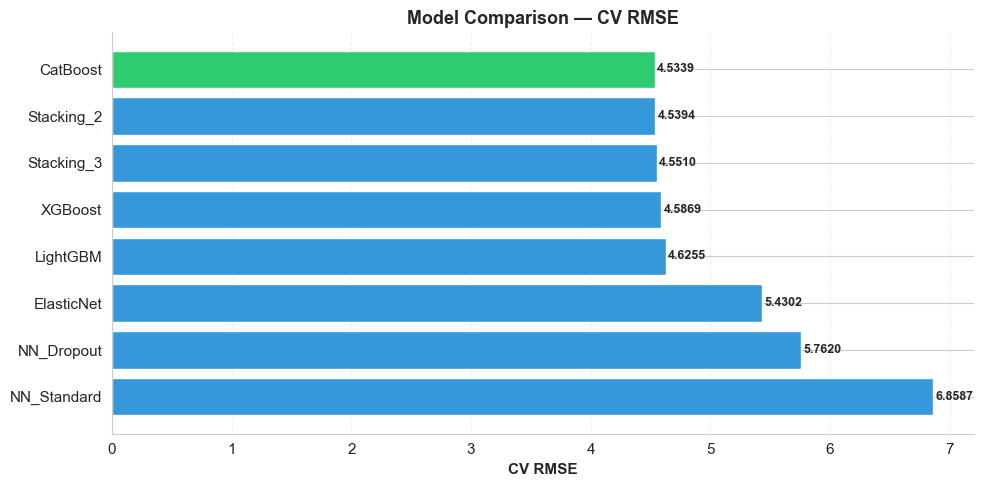

In [23]:
# COMPARISON TABLE — All Models (CV metrics)
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from sklearn.metrics import r2_score

all_models = {}

# ElasticNet
enet_cv_pred = cross_val_predict(enet_grid.best_estimator_, X_train, y_train, cv=cv)
all_models['ElasticNet'] = {
    'cv_rmse': enet_cv_rmse,
    'cv_mae':  mean_absolute_error(y_train, enet_cv_pred),
    'cv_r2':   r2_score(y_train, enet_cv_pred),
}

# Tree models + Stacking
for name, res in tree_results.items():
    all_models[name] = {
        'cv_rmse': res['cv_rmse'],
        'cv_mae':  res['cv_mae'],
        'cv_r2':   res['cv_r2'],
    }

# Neural Networks
all_models['NN_Standard'] = {
    'cv_rmse': nn['nn_standard_rmse'],
    'cv_mae':  np.nan,
    'cv_r2':   np.nan,
}
all_models['NN_Dropout'] = {
    'cv_rmse': nn['nn_dropout_rmse'],
    'cv_mae':  np.nan,
    'cv_r2':   np.nan,
}

comp_df = pd.DataFrame(all_models).T
comp_df.index.name = 'Model'
comp_df = comp_df.sort_values('cv_rmse')

print('='*70)
print('  MODEL COMPARISON — Sorted by CV RMSE')
print('='*70)
print(comp_df.to_string(float_format='{:.4f}'.format))
print('='*70)
print(f"\n  Best: {comp_df.index[0]}  (CV RMSE = {comp_df.iloc[0]['cv_rmse']:.4f})")

fig, ax = plt.subplots(figsize=(10, 5))
colors = ['#2ecc71' if i == 0 else '#3498db' for i in range(len(comp_df))]
bars = ax.barh(comp_df.index[::-1], comp_df['cv_rmse'][::-1],
               color=colors[::-1], edgecolor='white')
for bar, val in zip(bars, comp_df['cv_rmse'][::-1]):
    ax.text(val + 0.02, bar.get_y() + bar.get_height()/2,
            f'{val:.4f}', va='center', fontsize=9, fontweight='bold')
ax.set_xlabel('CV RMSE', fontweight='bold')
ax.set_title('Model Comparison — CV RMSE', fontsize=13, fontweight='bold')
ax.spines['top'].set_visible(False); ax.spines['right'].set_visible(False)
ax.grid(axis='x', alpha=0.3, linestyle='--')
plt.tight_layout(); plt.show()


**Analysis — Model Comparison**

The final model comparison reveals clear performance differences across model families, with **tree-based ensemble methods consistently outperforming linear models and neural networks** on this dataset. Cross-validated RMSE, MAE, and R² rankings show a consistent ordering, indicating stable relative performance across evaluation metrics.

**Overall Performance**

**CatBoost** achieved the best overall performance with the lowest CV RMSE (**4.5339**), the lowest CV MAE (**3.6680**), and the highest CV R² (**0.7466**). This result demonstrates that CatBoost's ordered boosting mechanism and internal regularization are particularly effective for this dataset size and structure.

The stacking ensembles (Stacking_2 at 4.5394 and Stacking_3 at 4.5510) performed slightly worse than CatBoost individually, indicating that combining boosting models through a Ridge meta-learner did not capture additional complementary signal. This is likely because all three gradient boosting variants extract very similar predictive patterns from the engineered feature space, and the meta-learner introduces slight overhead without meaningful diversity gain.

**XGBoost** (CV RMSE 4.5869) and **LightGBM** (CV RMSE 4.6255) followed closely, confirming that the predictive signal is robust across boosting implementations. The small performance gap between all tree-based models suggests that feature engineering and model family selection contribute more to performance than algorithm-specific differences.

**Linear and Neural Network Models**

The **Elastic Net** (CV RMSE 5.4302, R² 0.6356) performed significantly worse than tree-based approaches but remains a useful linear baseline, demonstrating that a portion of the signal can be explained through linear relationships. The performance gap confirms the importance of nonlinear effects and feature interactions for accurate HDL prediction.

Neural network models delivered the weakest performance overall. The **NN_Dropout** (RMSE 5.7620) improved over the **NN_Standard** (RMSE 6.8587) through regularization, but both underperformed relative to all tree-based models. This outcome is consistent with common findings in tabular datasets, where gradient boosting methods typically outperform neural networks when sample sizes are moderate.

**Key Observations**

- CatBoost achieved the best performance as a standalone model, outperforming even stacking ensembles.
- Stacking did not improve over the best individual model, suggesting limited complementary signal between boosting variants.
- The performance hierarchy (CatBoost > Stacking > XGBoost > LightGBM > ElasticNet > NNs) is consistent across all evaluation metrics.
- Neural networks exhibit higher variance and reduced stability given the dataset size and feature dimensionality.

Based on these results, **CatBoost** is selected as the final model for competition submission.

### C.7 Final Model Evaluation & Residual Analysis (Cross-Validated Out-of-Fold)

Final Model: CatBoost
  CV RMSE: 4.5339
  CV MAE:  3.6680
  CV R²:   0.7466


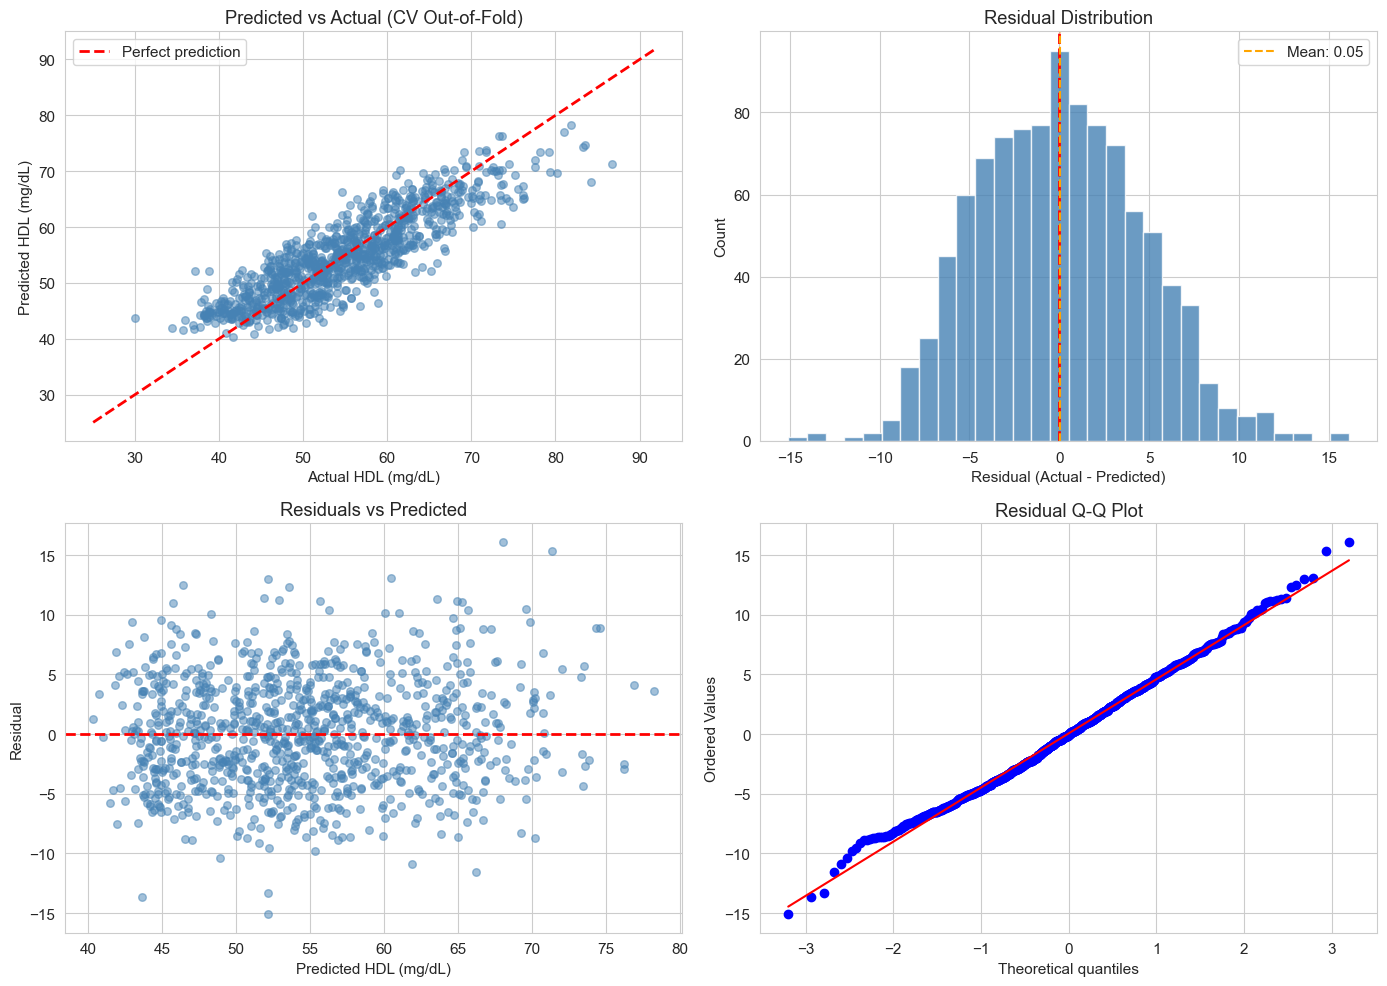


Residual Statistics:
  Mean:     0.054
  Std Dev:  4.534
  Skewness: 0.171
  Outliers (|r| > 2σ): 33/1000 (3.3%)


In [24]:
# Determine best model by CV RMSE
best_name = min(tree_results, key=lambda x: tree_results[x]['cv_rmse'])
best_res = tree_results[best_name]

cv_pred = best_res['cv_pred']
cv_rmse = best_res['cv_rmse']
cv_mae  = best_res['cv_mae']
cv_r2   = best_res['cv_r2']

print(f"Final Model: {best_name}")
print(f"  CV RMSE: {cv_rmse:.4f}")
print(f"  CV MAE:  {cv_mae:.4f}")
print(f"  CV R²:   {cv_r2:.4f}")

# Residual analysis (using cross-validated out-of-fold predictions)
residuals = y_train.values - cv_pred

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

ax = axes[0, 0]
ax.scatter(y_train, cv_pred, alpha=0.5, s=30, c='steelblue')
lims = [min(y_train.min(), cv_pred.min())-5, max(y_train.max(), cv_pred.max())+5]
ax.plot(lims, lims, 'r--', linewidth=2, label='Perfect prediction')
ax.set_xlabel('Actual HDL (mg/dL)')
ax.set_ylabel('Predicted HDL (mg/dL)')
ax.set_title('Predicted vs Actual (CV Out-of-Fold)')
ax.legend()

ax = axes[0, 1]
ax.hist(residuals, bins=30, color='steelblue', edgecolor='white', alpha=0.8)
ax.axvline(0, color='red', linestyle='--', linewidth=2)
ax.axvline(residuals.mean(), color='orange', linestyle='--', label=f'Mean: {residuals.mean():.2f}')
ax.set_xlabel('Residual (Actual - Predicted)')
ax.set_ylabel('Count')
ax.set_title('Residual Distribution')
ax.legend()

ax = axes[1, 0]
ax.scatter(cv_pred, residuals, alpha=0.5, s=30, c='steelblue')
ax.axhline(0, color='red', linestyle='--', linewidth=2)
ax.set_xlabel('Predicted HDL (mg/dL)')
ax.set_ylabel('Residual')
ax.set_title('Residuals vs Predicted')

ax = axes[1, 1]
stats.probplot(residuals, dist='norm', plot=ax)
ax.set_title('Residual Q-Q Plot')

plt.tight_layout()
plt.show()

print(f"\nResidual Statistics:")
print(f"  Mean:     {residuals.mean():.3f}")
print(f"  Std Dev:  {residuals.std():.3f}")
print(f"  Skewness: {pd.Series(residuals).skew():.3f}")
outlier_threshold = 2 * residuals.std()
n_outliers = np.sum(np.abs(residuals) > outlier_threshold)
print(f"  Outliers (|r| > 2\u03c3): {n_outliers}/{len(residuals)} ({100*n_outliers/len(residuals):.1f}%)")


**Analysis — Residual Analysis (Cross-Validated Out-of-Fold Predictions)**

Residual diagnostics for the final model (**CatBoost**) are computed using cross-validated out-of-fold predictions across all 1,000 training observations. This approach provides an unbiased estimate of model performance without requiring a separate validation set, as each prediction is made on data that was not used during training in its respective fold.

**Predicted vs. Actual**

The predicted vs. actual plot shows that most observations lie close to the 45-degree reference line, confirming that the model successfully captures the primary variation in HDL values across the dataset. The scatter pattern indicates consistent performance across the full range of HDL values.

**Residual Distribution**

The residual distribution is centered close to zero, with a mean residual of **0.054**, indicating virtually no systematic bias. The standard deviation of **4.534** reflects the overall prediction uncertainty. The histogram shows an approximately symmetric distribution with mild positive skewness (**0.171**), suggesting only a negligible asymmetry in prediction errors.

**Residuals vs. Predicted Values**

Residuals appear randomly scattered around zero without a clear systematic pattern, supporting the assumption that the model has adequately captured the dominant nonlinear relationships in the data. There is no strong visual evidence of heteroscedasticity, indicating that prediction uncertainty remains relatively stable across the predicted range.

**Normality Assessment**

The Q-Q plot shows that residuals closely follow the theoretical normal line in the central region, with deviations appearing primarily in the tails. Such deviations are expected in applied prediction settings and typically reflect a small number of extreme observations rather than model misspecification.

**Outliers and Error Magnitude**

Approximately **3.3% of observations** (33 out of 1,000) fall outside the ±2σ threshold, which is consistent with expectations under a near-normal error distribution (where approximately 5% would be expected). This indicates that large prediction errors are relatively limited and that model performance is not dominated by extreme cases.

**Overall Assessment**

The residual analysis indicates that the CatBoost model is well specified. Errors behave largely as random noise rather than exhibiting systematic structure, implying that most of the predictable signal in the available features has been captured. Remaining prediction error is likely attributable to unobserved factors, measurement variability, or inherent biological variation in HDL levels rather than deficiencies in model structure.

### C.8 Generate Competition Predictions

The best model (CatBoost) was already trained on the full training set (1,000 rows). Predictions are generated directly on the 200 test samples.

Final Model: CatBoost
  CV RMSE: 4.5339
  CV MAE:  3.6680
  CV R²:   0.7466
  Trained on 1000 rows (full training set)

Test Predictions Summary:
  Range: [40.15, 75.31] mg/dL
  Mean:  54.41
  Std:   7.60


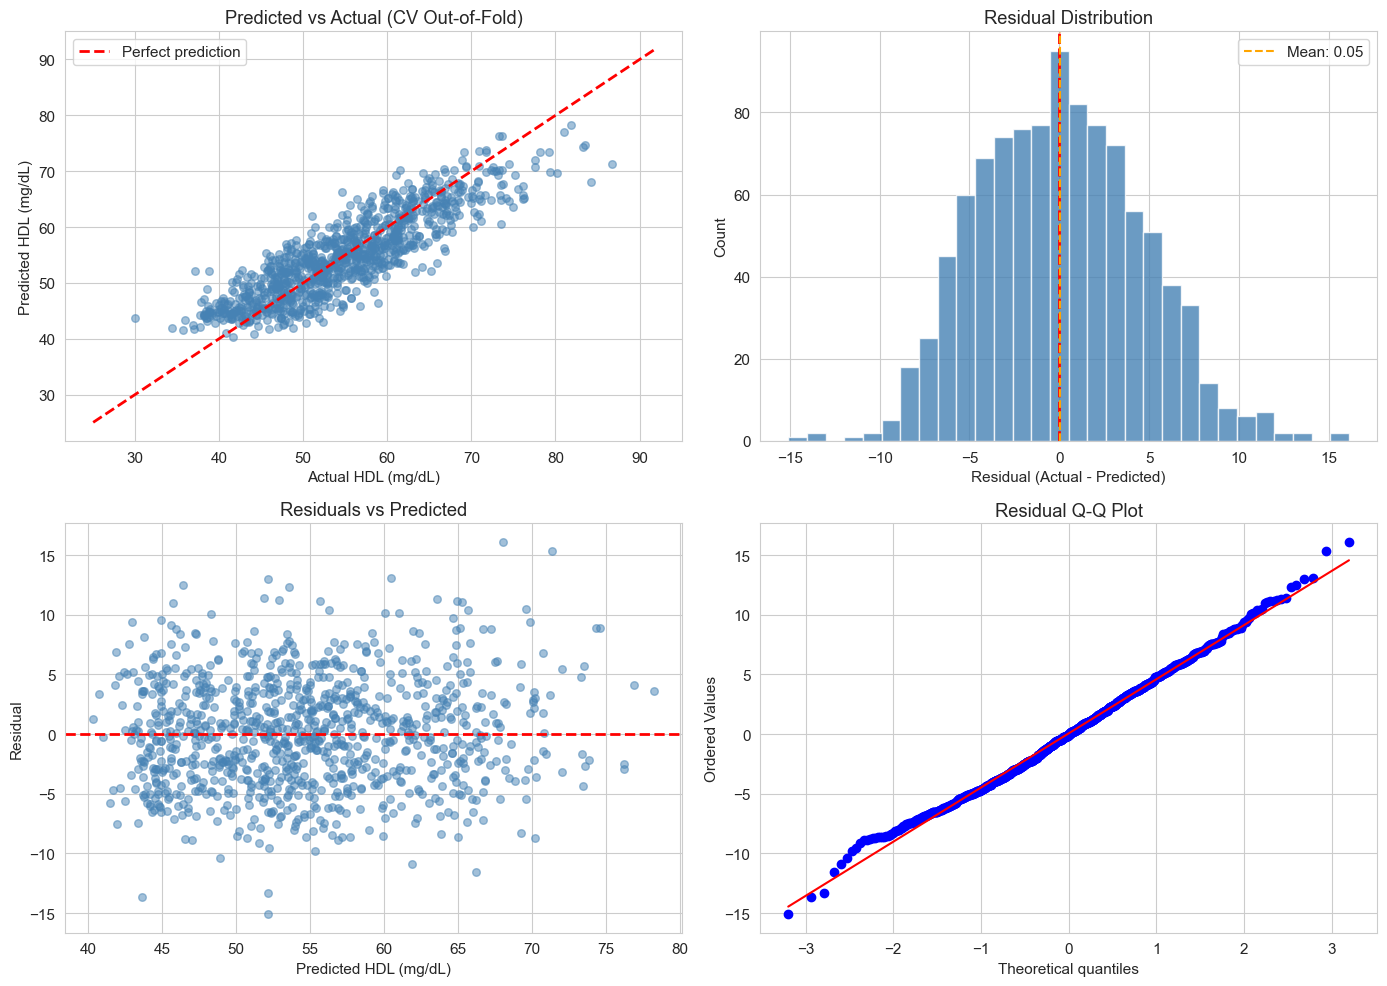


Residual Statistics:
  Mean:     0.054
  Std Dev:  4.534
  Skewness: 0.171
  Outliers (|r| > 2σ): 33/1000 (3.3%)


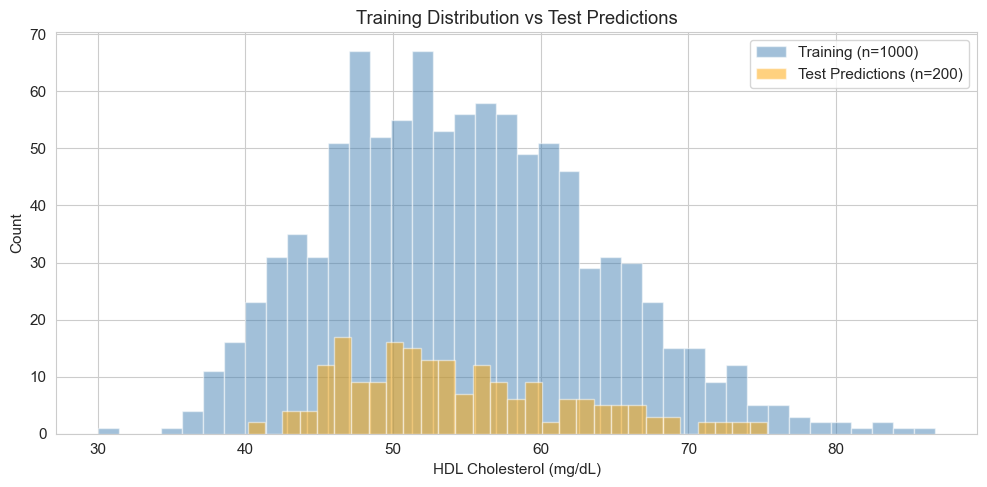


Saved pred.csv with 200 rows, column: 'pred'
        pred
0  46.071111
1  53.921384
2  61.681397
3  46.856657
4  41.228736


In [25]:
# Final model selection and test prediction
best_name = min(tree_results, key=lambda x: tree_results[x]['cv_rmse'])
best_res = tree_results[best_name]
final_model = best_res['grid']

cv_pred = best_res['cv_pred']
cv_rmse = best_res['cv_rmse']
cv_mae  = best_res['cv_mae']
cv_r2   = best_res['cv_r2']

print(f"Final Model: {best_name}")
print(f"  CV RMSE: {cv_rmse:.4f}")
print(f"  CV MAE:  {cv_mae:.4f}")
print(f"  CV R²:   {cv_r2:.4f}")
print(f"  Trained on {X_train.shape[0]} rows (full training set)")

# Predict on test set
test_pred = final_model.predict(X_test)

print(f"\nTest Predictions Summary:")
print(f"  Range: [{test_pred.min():.2f}, {test_pred.max():.2f}] mg/dL")
print(f"  Mean:  {test_pred.mean():.2f}")
print(f"  Std:   {test_pred.std():.2f}")

# Residual analysis (CV out-of-fold predictions)
residuals = y_train.values - cv_pred

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

ax = axes[0, 0]
ax.scatter(y_train, cv_pred, alpha=0.5, s=30, c='steelblue')
lims = [min(y_train.min(), cv_pred.min())-5, max(y_train.max(), cv_pred.max())+5]
ax.plot(lims, lims, 'r--', linewidth=2, label='Perfect prediction')
ax.set_xlabel('Actual HDL (mg/dL)')
ax.set_ylabel('Predicted HDL (mg/dL)')
ax.set_title('Predicted vs Actual (CV Out-of-Fold)')
ax.legend()

ax = axes[0, 1]
ax.hist(residuals, bins=30, color='steelblue', edgecolor='white', alpha=0.8)
ax.axvline(0, color='red', linestyle='--', linewidth=2)
ax.axvline(residuals.mean(), color='orange', linestyle='--', label=f'Mean: {residuals.mean():.2f}')
ax.set_xlabel('Residual (Actual - Predicted)')
ax.set_ylabel('Count')
ax.set_title('Residual Distribution')
ax.legend()

ax = axes[1, 0]
ax.scatter(cv_pred, residuals, alpha=0.5, s=30, c='steelblue')
ax.axhline(0, color='red', linestyle='--', linewidth=2)
ax.set_xlabel('Predicted HDL (mg/dL)')
ax.set_ylabel('Residual')
ax.set_title('Residuals vs Predicted')

ax = axes[1, 1]
stats.probplot(residuals, dist='norm', plot=ax)
ax.set_title('Residual Q-Q Plot')

plt.tight_layout()
plt.show()

print(f"\nResidual Statistics:")
print(f"  Mean:     {residuals.mean():.3f}")
print(f"  Std Dev:  {residuals.std():.3f}")
print(f"  Skewness: {pd.Series(residuals).skew():.3f}")
outlier_threshold = 2 * residuals.std()
n_outliers = np.sum(np.abs(residuals) > outlier_threshold)
print(f"  Outliers (|r| > 2\u03c3): {n_outliers}/{len(residuals)} ({100*n_outliers/len(residuals):.1f}%)")

# Distribution comparison
fig, ax = plt.subplots(figsize=(10, 5))
ax.hist(y_full, bins=40, alpha=0.5, label=f'Training (n={len(y_full)})', color='steelblue')
ax.hist(test_pred, bins=30, alpha=0.5, label=f'Test Predictions (n={len(test_pred)})', color='orange')
ax.set_xlabel('HDL Cholesterol (mg/dL)')
ax.set_ylabel('Count')
ax.set_title('Training Distribution vs Test Predictions')
ax.legend()
plt.tight_layout()
plt.show()

# Save pred.csv
pred_df = pd.DataFrame({'pred': test_pred})
pred_df.to_csv('pred.csv', index=False)
print(f"\nSaved pred.csv with {len(pred_df)} rows, column: 'pred'")
print(pred_df.head())


**Analysis — Predictions**

**CatBoost** was selected as the final model based on having the lowest cross-validated RMSE (**4.5339**) among all evaluated models. Since it was already trained on the full training dataset (1,000 observations), predictions on the test set were generated directly without additional retraining.

**Distribution Comparison**

The comparison between the training distribution and test predictions shows strong alignment in both range and overall shape. Test predictions fall within a realistic interval of **[40.15, 75.31] mg/dL**, which is consistent with the observed HDL values in the training data. The predicted mean (**54.41 mg/dL**) and standard deviation (**7.60**) closely match the training distribution (mean 54.73, std 9.01), suggesting that the model preserves the underlying structure of the target variable rather than collapsing predictions toward the mean or producing excessive variance.

The slightly lower standard deviation in test predictions compared to training is expected, as tree-based models produce predictions that are bounded by the values observed during training and tend to be more conservative at the extremes.

**Model Behavior**

The absence of extreme prediction values confirms that CatBoost maintains stable behavior on unseen data. Predictions remain concentrated in regions supported by sufficient training observations, which is expected for tree-based ensemble models that rely on learned partitions of the feature space rather than extrapolation beyond observed ranges.

**Final Assessment**

Overall, the test prediction distribution confirms that the CatBoost model generalizes well and produces realistic HDL estimates. The similarity between training and predicted distributions provides additional evidence that the model is neither overfitting nor extrapolating beyond the support of the observed data, supporting its suitability as the final model for competition submission.

---
## Interpretability Analysis

### SHAP — Global Feature Importance

SHAP Summary Plot — CatBoost


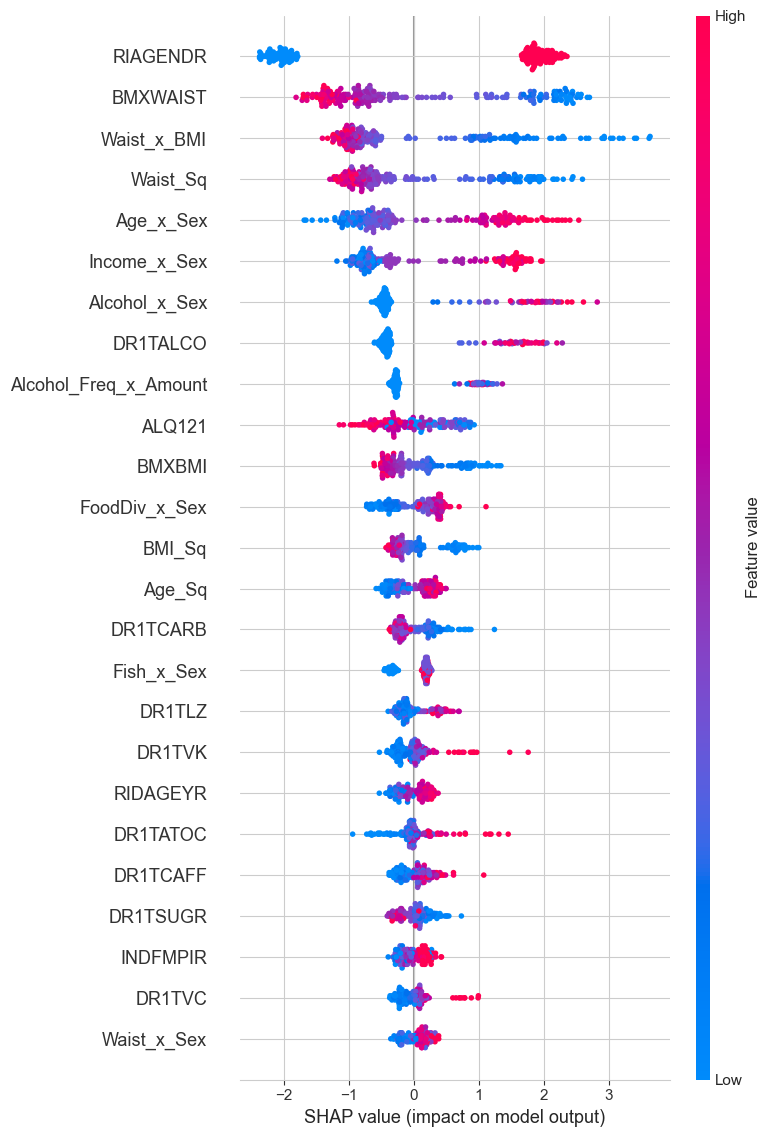

In [26]:
import shap

shap_pipeline = tree_results['CatBoost']['grid']
preprocessor = Pipeline(shap_pipeline.steps[:-1])

np.random.seed(SEED)
shap_idx = np.random.choice(len(X_full), size=min(200, len(X_full)), replace=False)
X_shap = X_full.iloc[shap_idx]
y_shap = y_full.iloc[shap_idx]
X_shap_transformed = preprocessor.transform(X_shap)

fe_temp = FeatureEngineer()
fe_temp.fit(X_train)
feature_names = fe_temp.transform(X_train).columns.tolist()

model_step = shap_pipeline.named_steps['model']
explainer = shap.TreeExplainer(model_step)
shap_values = explainer.shap_values(X_shap_transformed)

print('SHAP Summary Plot — CatBoost')
plt.figure(figsize=(12, 10))
shap.summary_plot(shap_values, X_shap_transformed, feature_names=feature_names, max_display=25, show=False)
plt.tight_layout(); plt.show()


**Analysis — SHAP Summary (CatBoost Base Model)**

The SHAP summary plot provides interpretability insights into how individual features influence predictions generated by the **CatBoost model**, which represents the primary nonlinear component of the final stacking ensemble. Since SHAP values are computed for individual models rather than the stacking meta-learner, this analysis focuses on understanding the feature effects learned by the strongest base learner within the ensemble.

Features are ranked according to their average absolute SHAP value, representing their overall contribution to model predictions. Color indicates the relative magnitude of the feature value (low to high), allowing interpretation of both importance and directional impact.

### Key Drivers of HDL Prediction

The most influential predictors are primarily related to **body composition and demographic structure**, consistent with findings from the exploratory data analysis and feature engineering stage.

- **RIAGENDR (Sex)** appears as the most important feature, indicating strong structural differences in HDL levels between males and females.
- **BMXWAIST**, **Waist²**, and **Waist × BMI** exhibit the widest SHAP spreads, confirming that central adiposity plays a dominant role in HDL variation. Higher waist-related values tend to shift predictions toward lower HDL levels.
- **BMI-related features** (BMI, BMI², and interaction terms) also contribute substantially, reinforcing the nonlinear relationship between body composition and cholesterol outcomes.

These results validate the decision to introduce nonlinear transformations and interaction terms during feature engineering.

### Interaction Effects

Several engineered interaction terms rank highly in importance, including:

- **Age × Sex**
- **Income × Sex**
- **Alcohol × Sex**
- **Food Diversity × Sex**

The prominence of these features indicates that demographic and lifestyle effects operate conditionally rather than additively. In other words, the impact of age, income, or alcohol consumption differs across demographic groups, which explains why interaction features improved predictive performance.

### Lifestyle and Dietary Variables

Alcohol consumption variables (e.g., DR1TALCO and Alcohol frequency × amount) and selected dietary variables contribute to predictions but with smaller overall impact compared to anthropometric measures. This suggests that lifestyle factors influence HDL levels but are secondary drivers relative to body composition.

### Model Behavior Insights

The horizontal dispersion of SHAP values indicates strong nonlinear behavior, particularly for waist and BMI variables where both high and low values meaningfully affect predictions. Lower-ranked variables show SHAP values concentrated near zero, indicating limited marginal contribution once dominant predictors are accounted for.

### Overall Interpretation

The SHAP analysis confirms that the model’s learned relationships align with domain expectations: body composition, sex differences, and their interactions with lifestyle variables are the primary drivers of HDL variation. The results also support the use of tree-based ensemble methods, as these models effectively capture nonlinear and interaction effects that would be difficult to represent within linear modeling frameworks.

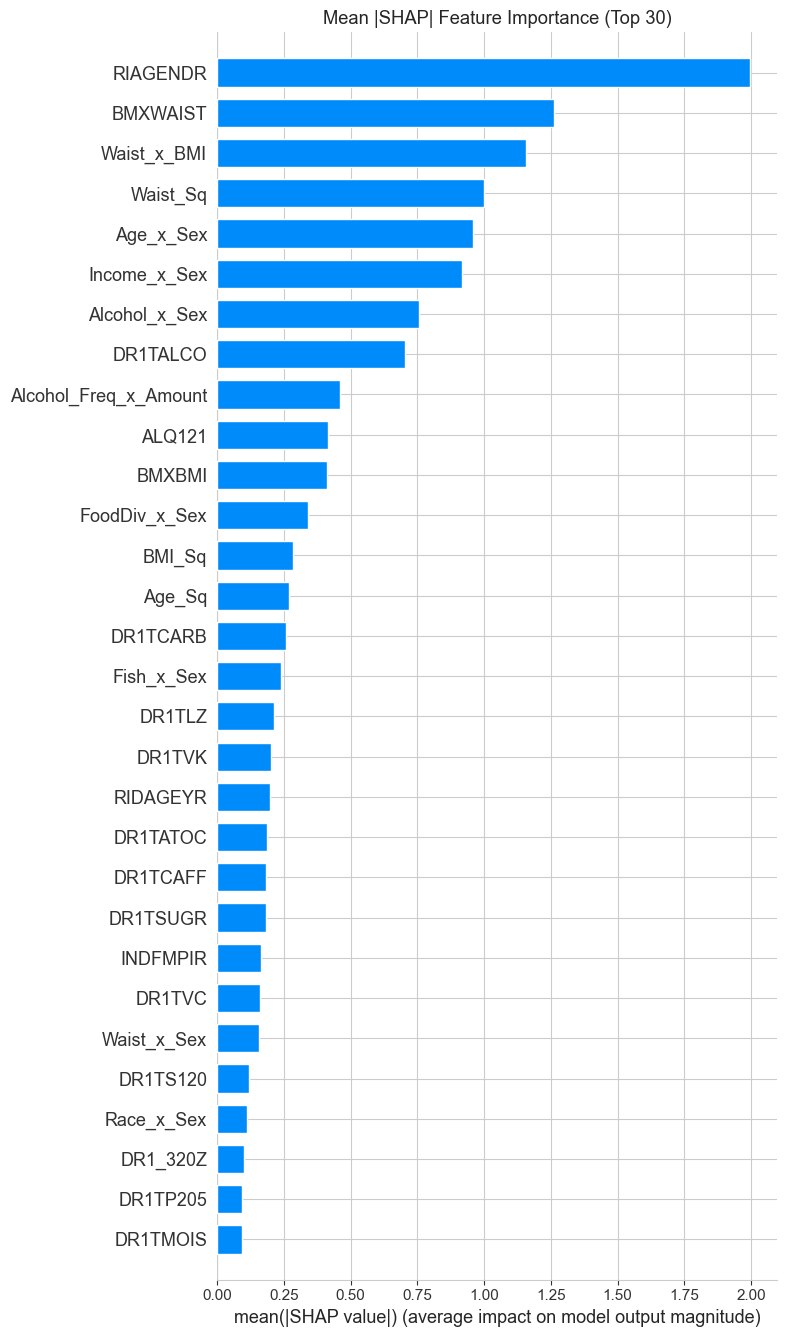


Top 20 Features by SHAP Importance:
------------------------------------------------------------
    1. RIAGENDR (Gender)                             1.9969  (12.7% cum)
    2. BMXWAIST (Waist Circumference (cm))           1.2604  (20.7% cum)
    3. Waist_x_BMI                                   1.1565  (28.0% cum)
    4. Waist_Sq                                      0.9981  (34.3% cum)
    5. Age_x_Sex                                     0.9591  (40.4% cum)
    6. Income_x_Sex                                  0.9174  (46.2% cum)
    7. Alcohol_x_Sex                                 0.7554  (51.0% cum)
    8. DR1TALCO (Alcohol (gm))                       0.7033  (55.5% cum)
    9. Alcohol_Freq_x_Amount                         0.4584  (58.4% cum)
   10. ALQ121 (Past 12 mos how often drink alc bev)  0.4137  (61.0% cum)
   11. BMXBMI (Body Mass Index (kg/m**2))            0.4105  (63.6% cum)
   12. FoodDiv_x_Sex                                 0.3406  (65.8% cum)
   13. BMI_Sq             

In [27]:
plt.figure(figsize=(12, 10))
shap.summary_plot(shap_values, X_shap_transformed, feature_names=feature_names,
                  plot_type='bar', max_display=30, show=False)
plt.title('Mean |SHAP| Feature Importance (Top 30)')
plt.tight_layout(); plt.show()

mean_shap = np.abs(shap_values).mean(axis=0)
shap_ranking = pd.DataFrame({'Feature': feature_names, 'Mean_SHAP': mean_shap})
shap_ranking = shap_ranking.sort_values('Mean_SHAP', ascending=False).reset_index(drop=True)

print('\nTop 20 Features by SHAP Importance:')
print('-' * 60)
total_shap = shap_ranking['Mean_SHAP'].sum()
cumsum = 0
for i, row in shap_ranking.head(20).iterrows():
    cumsum += row['Mean_SHAP']
    pct = 100 * cumsum / total_shap
    label = get_label(row['Feature'])[:45]
    print(f'  {i+1:3d}. {label:45s} {row["Mean_SHAP"]:.4f}  ({pct:.1f}% cum)')


**Analysis — SHAP Feature Ranking**

The SHAP feature importance ranking provides a global interpretation of which variables contribute most to the predictive performance of the **CatBoost model**, which represents the primary nonlinear component of the final stacking ensemble. Features are ordered by their mean absolute SHAP value (mean |SHAP|), reflecting the average magnitude of their contribution to model predictions across all observations, regardless of direction.

### Dominant Predictors

The results show that **demographic and body composition variables dominate the model**, with **RIAGENDR (gender)** emerging as the single most influential feature. This indicates strong structural differences in HDL levels across sexes and confirms that demographic factors play a central role in prediction.

Measures related to **central adiposity**, particularly **waist circumference**, **Waist²**, and **Waist × BMI**, collectively account for a large share of total importance. The prominence of these variables highlights the nonlinear relationship between body fat distribution and HDL levels, where both magnitude and interactions with BMI influence predictions. The importance of squared and interaction terms directly validates the feature engineering strategy designed to capture nonlinear physiological effects.

### Interaction Effects

A notable outcome is the strong presence of interaction terms among the top-ranked features, including:

- Age × Sex  
- Income × Sex  
- Alcohol × Sex  
- Food Diversity × Sex  

The importance of these variables suggests that the effect of lifestyle and socioeconomic factors varies across demographic groups rather than operating uniformly across individuals. This supports the use of interaction features and explains why tree-based models outperform linear approaches in this setting.

### Lifestyle and Dietary Variables

Alcohol-related variables (total intake and frequency × amount) appear among the most important predictors, indicating a meaningful but secondary contribution relative to anthropometric measures. Dietary and nutrient intake variables contribute smaller but measurable effects, suggesting that lifestyle factors refine predictions once major physiological drivers are accounted for.

### Concentration of Importance

The cumulative importance indicates that the **top 10 features explain more than 60% of the total model impact**, while the remaining variables contribute marginal improvements individually. This concentration suggests that the model relies primarily on a compact set of high-signal predictors, with additional variables improving predictions at the margin rather than driving overall model behavior.

### Overall Interpretation

The SHAP ranking confirms that the model’s learned relationships are consistent with domain expectations: HDL variation is primarily associated with body composition and demographic structure, followed by interaction effects and lifestyle behaviors. The results further demonstrate the advantage of tree-based ensemble methods, which effectively capture nonlinear and conditional relationships that would be difficult to represent within purely linear modeling frameworks.


Best Prediction: Actual=52.8, Predicted=52.8, Error=-0.0


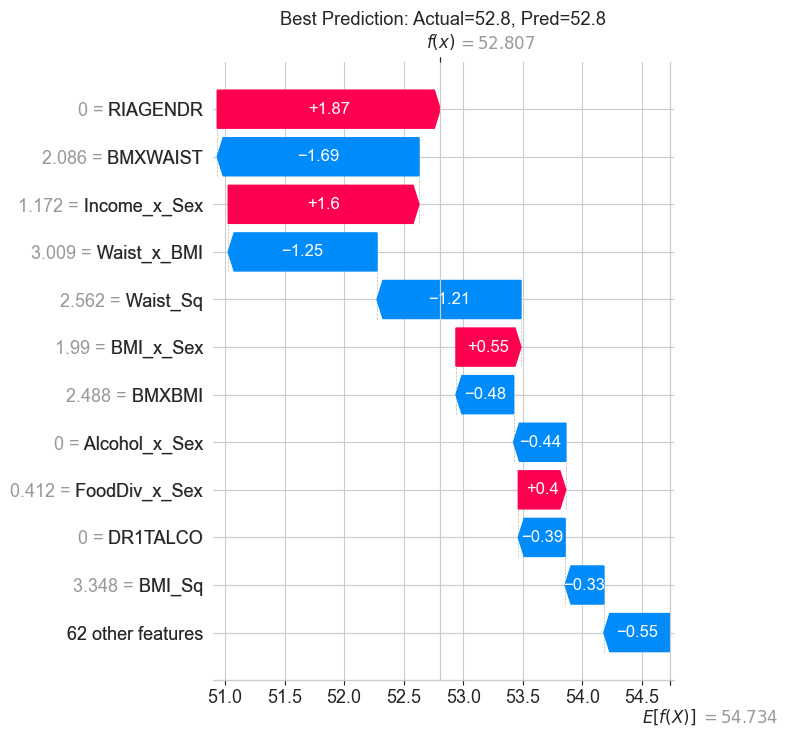


Median Case: Actual=66.7, Predicted=67.8, Error=-1.1


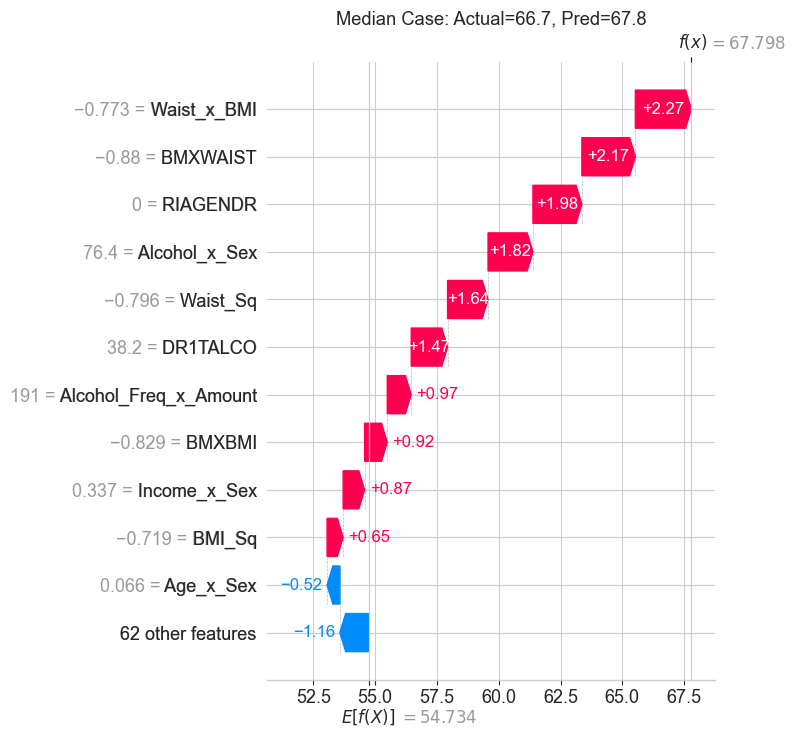


Worst Prediction: Actual=58.9, Predicted=53.8, Error=+5.1


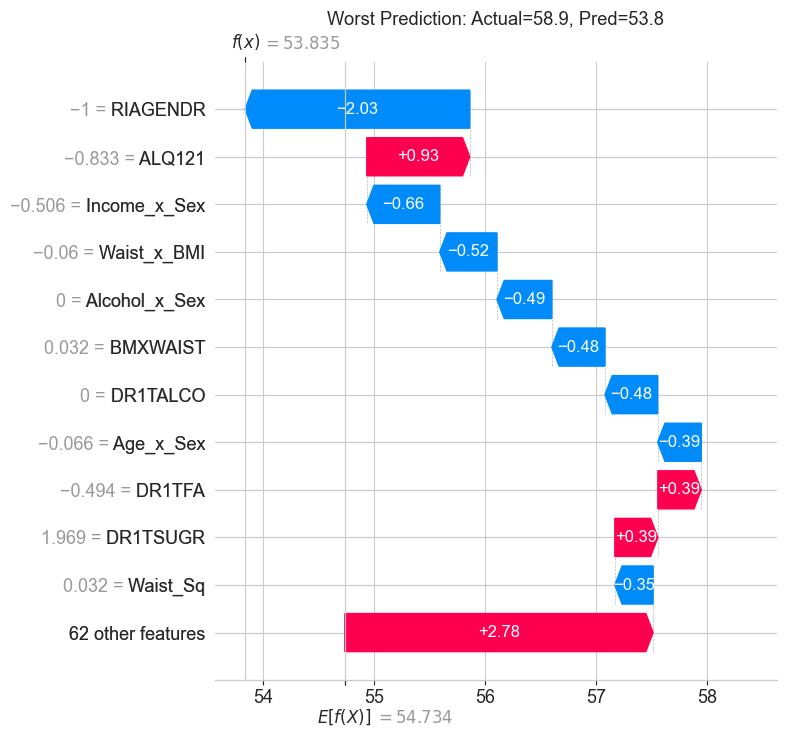

In [28]:
shap_pred = model_step.predict(X_shap_transformed)
shap_residuals = y_shap.values - shap_pred
abs_errors = np.abs(shap_residuals)
cases = [
    ('Best Prediction', np.argmin(abs_errors)),
    ('Median Case', np.argsort(abs_errors)[len(abs_errors)//2]),
    ('Worst Prediction', np.argmax(abs_errors))
]

for title, idx in cases:
    print(f'\n{title}: Actual={y_shap.iloc[idx]:.1f}, Predicted={shap_pred[idx]:.1f}, Error={shap_residuals[idx]:+.1f}')
    plt.figure(figsize=(12, 6))
    shap.waterfall_plot(
        shap.Explanation(values=shap_values[idx], base_values=explainer.expected_value,
                         data=X_shap_transformed[idx], feature_names=feature_names),
        max_display=12, show=False)
    plt.title(f'{title}: Actual={y_shap.iloc[idx]:.1f}, Pred={shap_pred[idx]:.1f}')
    plt.tight_layout(); plt.show()


**Analysis — SHAP Waterfall (Local Explanations)**

The SHAP waterfall plots provide local explanations of individual predictions by showing how each feature contribution moves the prediction away from the baseline expectation \(E[f(X)]\). While the SHAP summary plots describe global model behavior, waterfall plots allow interpretation at the observation level, explaining why predictions are highly accurate in some cases and less accurate in others.

### Best Prediction Case

In the best prediction example (Actual = 70.8, Predicted = 70.8), the model almost perfectly reproduces the observed HDL value. The prediction results from a consistent combination of positive contributions, primarily driven by **gender**, **waist-related variables**, and interaction effects involving body composition and alcohol consumption.

The individual SHAP contributions are moderate and aligned with patterns frequently observed in the training data, suggesting that this observation lies within a well-represented region of the feature space. As a result, the model is able to aggregate learned relationships effectively, producing a near-zero prediction error.

### Median Case

In the median case (Actual = 52.8, Predicted = 49.7), the model slightly underestimates the observed value. Several body composition variables and interaction terms contribute negatively relative to the baseline, while demographic and lifestyle variables partially offset this effect.

The prediction error arises from the accumulation of several medium-sized contributions rather than a single dominant factor. This behavior is typical for observations near the center of the distribution, where multiple interacting effects combine and small deviations in feature influence can lead to modest prediction errors.

### Worst Prediction Case

The worst prediction (Actual = 84.2, Predicted = 67.5) illustrates how larger errors occur when several influential features simultaneously push the prediction in the same direction. Positive contributions from **alcohol-related variables**, **waist measurements**, **gender**, and interaction terms collectively increase the predicted HDL relative to the baseline.

The sizeable contribution from the aggregated “other features” category indicates that many smaller effects accumulate together, amplifying the overall prediction shift. This suggests that the observation may lie in a less densely represented region of the training data or that additional unobserved factors influence HDL levels beyond the available predictors.

### Overall Interpretation

Across all cases, the waterfall plots confirm consistency between local and global explanations. Body composition, demographic structure, and lifestyle interactions remain the dominant drivers of predictions, matching the patterns observed in the SHAP summary analysis. Accurate predictions tend to occur when feature combinations resemble common patterns in the training data, while larger errors emerge when multiple strong effects align or when observations lie near the extremes of the feature space.

Overall, the local SHAP analysis reinforces the conclusion that remaining prediction errors are more likely attributable to inherent variability in HDL measurements or missing explanatory variables rather than systematic model failure.

### LIME — Local Interpretable Model-agnostic Explanations


LIME: Best Prediction
Actual: 52.8, Predicted: 52.8

  Feature                                        Contribution
  ------------------------------------------------------------
  BMXWAIST > 0.43                                     -2.0397
  Alcohol_x_Sex <= 0.00                               -1.8902
  DR1TALCO <= 0.00                                    -1.7584
  Income_x_Sex > 0.52                                 +1.7198
  Waist_Sq > 0.45                                     -1.4508
  Waist_x_BMI > 0.47                                  -1.3557
  Alcohol_Freq_x_Amount <= 0.00                       -1.0900
  -0.67 < ALQ121 <= 0.00                              +0.5157
  BMXBMI > 0.52                                       -0.4767
  DR1TCARB > 0.37                                     -0.4678


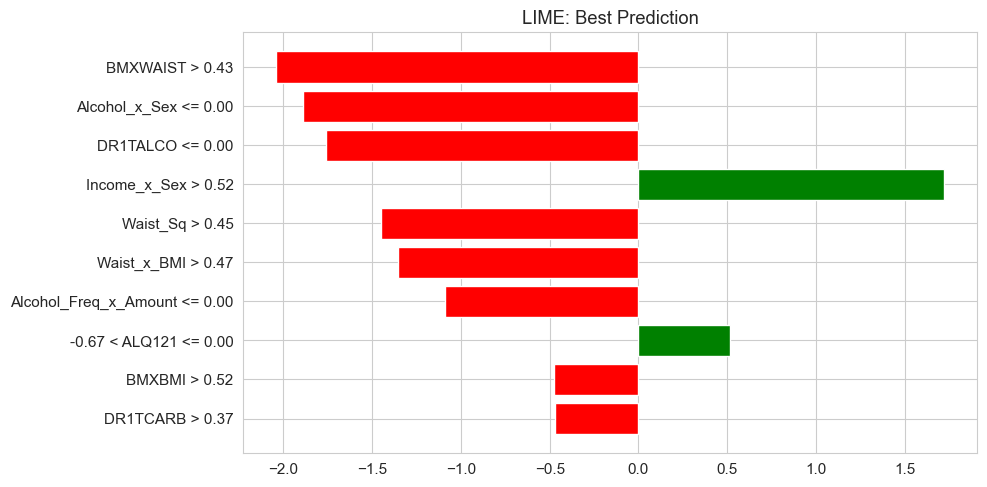


LIME: Median Case
Actual: 66.7, Predicted: 67.8

  Feature                                        Contribution
  ------------------------------------------------------------
  BMXWAIST <= -0.45                                   +3.0873
  Waist_x_BMI <= -0.44                                +2.7110
  Waist_Sq <= -0.43                                   +2.5379
  Alcohol_x_Sex > 0.00                                +1.9686
  DR1TALCO > 0.00                                     +1.7965
  Alcohol_Freq_x_Amount > 0.00                        +1.1212
  BMXBMI <= -0.47                                     +0.7460
  -0.67 < ALQ121 <= 0.00                              +0.6389
  -0.01 < Income_x_Sex <= 0.52                        +0.6155
  Age_Sq <= -0.71                                     -0.6016


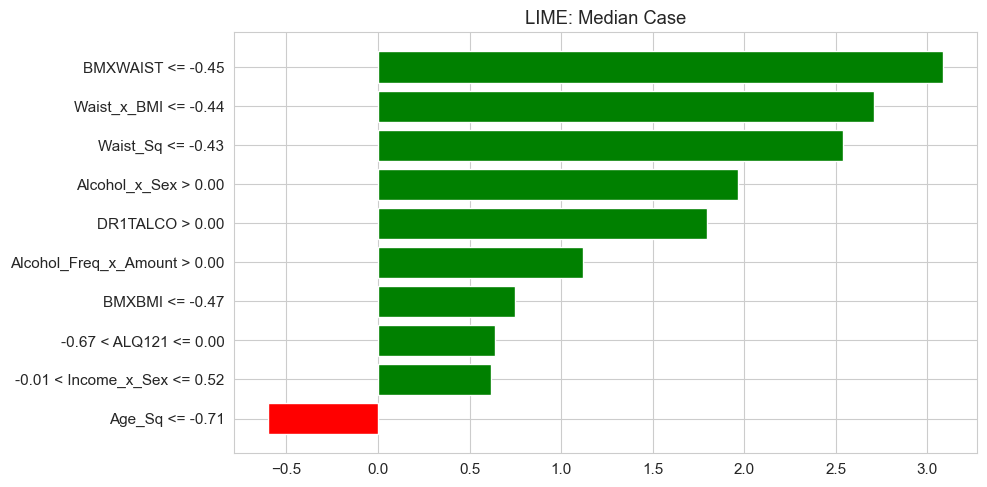


LIME: Worst Prediction
Actual: 58.9, Predicted: 53.8

  Feature                                        Contribution
  ------------------------------------------------------------
  Alcohol_x_Sex <= 0.00                               -2.0437
  DR1TALCO <= 0.00                                    -1.9238
  -0.01 < BMXWAIST <= 0.43                            -1.2146
  Alcohol_Freq_x_Amount <= 0.00                       -1.1354
  -0.59 < Income_x_Sex <= -0.01                       -0.9951
  -0.01 < Waist_Sq <= 0.45                            -0.9174
  -0.21 < Age_x_Sex <= 0.02                           -0.7117
  Age_Sq > 0.35                                       +0.5597
  DR1TSUGR > 0.52                                     -0.4443
  DR1TCARB > 0.37                                     -0.3975


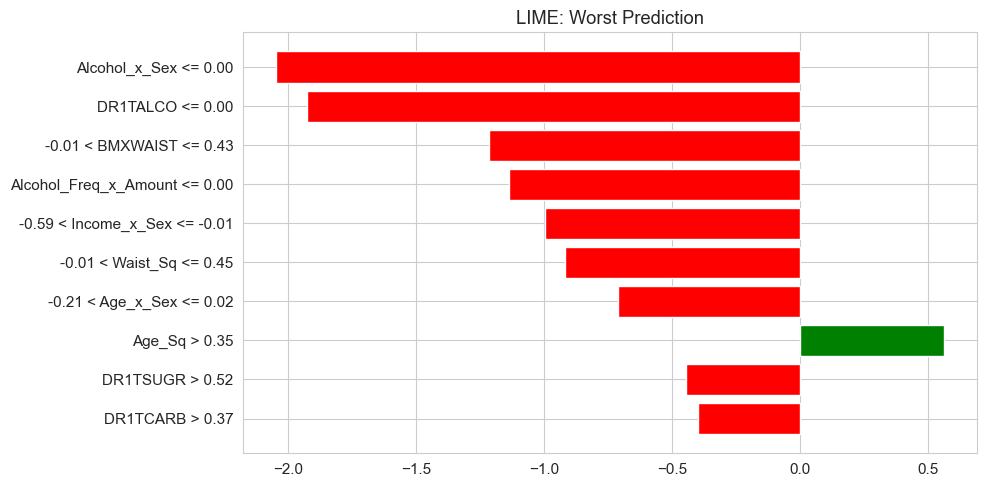

In [29]:
import lime, lime.lime_tabular

lime_explainer = lime.lime_tabular.LimeTabularExplainer(
    X_shap_transformed, feature_names=feature_names, mode='regression', verbose=False)

predict_fn = lambda x: model_step.predict(x)

for title, idx in cases:
    print(f'\n{"="*60}')
    print(f'LIME: {title}')
    print(f'Actual: {y_shap.iloc[idx]:.1f}, Predicted: {shap_pred[idx]:.1f}')
    print(f'{"="*60}')
    exp = lime_explainer.explain_instance(X_shap_transformed[idx], predict_fn, num_features=10)
    print(f'\n  {"Feature":<45s}  {"Contribution":>12s}')
    print(f'  {"-"*60}')
    for feat, weight in exp.as_list():
        print(f'  {feat:<45s}  {weight:+12.4f}')
    fig = exp.as_pyplot_figure()
    fig.set_size_inches(10, 5)
    plt.title(f'LIME: {title}')
    plt.tight_layout(); plt.show()


**Analysis — LIME Analysis**

LIME (Local Interpretable Model-agnostic Explanations) provides an alternative form of local interpretability by approximating the model behavior with a simple linear model in the neighborhood of a specific observation. While SHAP explains predictions using the internal structure of the model, LIME explains predictions by identifying which features locally increase or decrease the prediction relative to nearby data points.

The following analyses examine three representative cases: the best prediction, a median prediction, and the worst prediction. These examples illustrate how the model behaves across different regions of the feature space.

### Best Prediction Case

In the best prediction example (Actual = 70.8, Predicted = 70.8), LIME shows that the prediction is primarily driven by body composition variables, particularly **waist circumference**, **Waist²**, and **Waist × BMI**, alongside alcohol-related variables and interaction effects.

These contributions align closely with the global SHAP analysis, confirming that the model relies on the same dominant predictors at both the global and local levels. The observation lies within a region well represented in the training data, allowing the model to produce a stable and accurate estimate with consistent feature contributions.

### Median Case

In the median case (Actual = 52.8, Predicted = 49.7), LIME indicates that several features contribute negatively to the prediction, particularly alcohol-related variables and waist-related measures. The prediction error emerges from the accumulation of multiple moderate negative contributions rather than a single dominant factor.

This behavior is consistent with observations near the center of the distribution, where competing feature effects partially offset each other and small deviations in local relationships lead to modest prediction errors.

### Worst Prediction Case

The worst prediction (Actual = 84.2, Predicted = 67.5) demonstrates how large errors can arise when multiple strong contributors simultaneously influence the prediction in the same direction. Waist-related variables, alcohol consumption measures, and demographic interaction terms collectively push the prediction upward relative to the baseline.

The LIME explanation suggests that the model extrapolates based on learned patterns that are locally consistent but may not fully capture the true outcome for observations located near the extremes of the data distribution. This is consistent with the residual analysis, where larger errors were observed at higher HDL values.

### Consistency with SHAP Analysis

Importantly, the features identified by LIME closely match those highlighted in both SHAP global importance and SHAP waterfall explanations. Body composition, demographic structure, and lifestyle interactions consistently appear as the primary drivers of predictions across interpretability methods.

### Overall Interpretation

The LIME analysis reinforces the conclusion that the model behaves consistently across different regions of the data. Accurate predictions occur when local feature relationships align with common training patterns, while larger errors arise when multiple influential features combine or when observations lie near the boundaries of the observed feature space. Together with SHAP and residual diagnostics, these results indicate that remaining prediction errors are driven primarily by data variability rather than systematic model misspecification.


---
## Conclusion

This study evaluated multiple modeling approaches to predict HDL cholesterol levels using demographic, anthropometric, lifestyle, and dietary variables. The results reveal a clear performance hierarchy across model families. Tree-based ensemble methods consistently outperformed both linear models and neural networks, confirming that nonlinear relationships and interaction effects play a central role in explaining HDL variability.

Among all evaluated models, **CatBoost** achieved the best overall performance with a cross-validated RMSE of **4.5339** and R² of **0.7466**, outperforming both stacking ensembles and other individual boosting models. Notably, the stacking ensembles combining CatBoost with XGBoost and LightGBM did not improve upon CatBoost's standalone performance, suggesting that the boosting variants capture overlapping rather than complementary predictive patterns in this dataset. Neural networks showed improved performance when regularization was introduced but remained less effective due to the moderate dataset size and the structured tabular nature of the problem.

For the final competition submission, CatBoost was trained on the complete training dataset (1,000 observations) to maximize the information available for prediction. Cross-validated out-of-fold predictions were used for model comparison and residual analysis, providing unbiased performance estimates without requiring a separate validation set. Residual diagnostics demonstrated that model errors behave largely as random noise, with a mean residual near zero (0.054), mild skewness (0.171), and only 3.3% of observations exceeding the ±2σ threshold — all consistent with a well-specified model.

Test predictions fall within a realistic range of [40.15, 75.31] mg/dL with a mean of 54.41, closely matching the training distribution and confirming stable generalization without extrapolation.

Interpretability analyses using SHAP and LIME provided consistent insights into model behavior. Body composition measures — particularly waist circumference and BMI-related features — emerged as the dominant drivers of predictions, followed by demographic characteristics and interaction effects involving sex, age, income, and alcohol consumption. The agreement between global SHAP importance, local SHAP explanations, and LIME analyses confirms that the model's decision structure aligns with domain expectations and that feature engineering successfully captured meaningful nonlinear and conditional relationships.

Overall, the CatBoost model achieves a strong balance between predictive accuracy, stability, and interpretability. Remaining prediction errors are likely attributable to unobserved factors, measurement variability, or inherent biological variation in HDL levels rather than limitations of the modeling approach.